In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 16, 10
RANDOM_SEED = 42

In [2]:
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [3]:
data_age = pd.read_csv('age.csv',sep = ';')
data_admission = pd.read_csv('admission.csv',sep = ';')
data_signal = pd.read_csv('signal.csv',sep = ';')

In [4]:
from datetime import datetime, date, timedelta
data_admission['duration']= [int(i.days) for i in 
                             (pd.to_datetime(data_admission['date_discharge'])- pd.to_datetime(data_admission['date_admission']))]

In [5]:
data_all = [data_age,data_admission,data_signal]

In [6]:
from functools import reduce
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['pat_id'],
                                            how='left'), data_all)

In [7]:
df_merged.head()

Unnamed: 0_x  pat_id   age  Unnamed: 0_y date_admission date_discharge  \
0             0       0  35.0       23276.0     2016-01-05     2016-01-07   
1             0       0  35.0       23276.0     2016-01-05     2016-01-07   
2             0       0  35.0       23276.0     2016-01-05     2016-01-07   
3             0       0  35.0       23276.0     2016-01-05     2016-01-07   
4             0       0  35.0       23276.0     2016-01-05     2016-01-07   

   duration  Unnamed: 0  Unnamed: 0.1         day  hour       parameter  \
0       2.0         0.0           0.0  2016-01-05  23.0  blood_pressure   
1       2.0         1.0           1.0  2016-01-06   0.0  blood_pressure   
2       2.0         2.0           2.0  2016-01-06   1.0  blood_pressure   
3       2.0         3.0           3.0  2016-01-06   2.0  blood_pressure   
4       2.0         4.0           4.0  2016-01-06   3.0  blood_pressure   

        value  
0  104.543181  
1  110.542544  
2  133.832002  
3  133.067666  
4  134.566003

In [8]:
df_groupby =df_merged.pivot_table('value', ['pat_id', 'age','date_admission','date_discharge','duration','day','hour'],'parameter')

In [9]:
df_groupby.reset_index( drop=False, inplace=True )

In [10]:
df_groupby.head()

parameter  pat_id   age date_admission date_discharge  duration         day  \
0               0  35.0     2016-01-05     2016-01-07       2.0  2016-01-05   
1               0  35.0     2016-01-05     2016-01-07       2.0  2016-01-06   
2               0  35.0     2016-01-05     2016-01-07       2.0  2016-01-06   
3               0  35.0     2016-01-05     2016-01-07       2.0  2016-01-06   
4               0  35.0     2016-01-05     2016-01-07       2.0  2016-01-06   

parameter  hour  blood_pressure  respiration_rate  temperature  
0          23.0      104.543181               NaN          NaN  
1           0.0      110.542544               NaN          NaN  
2           1.0      133.832002               NaN          NaN  
3           2.0      133.067666               NaN          NaN  
4           3.0      134.566003               NaN          NaN

In [11]:
df_groupby.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71969 entries, 0 to 71968
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   pat_id            71969 non-null  int64  
 1   age               71969 non-null  float64
 2   date_admission    71969 non-null  object 
 3   date_discharge    71969 non-null  object 
 4   duration          71969 non-null  float64
 5   day               71969 non-null  object 
 6   hour              71969 non-null  float64
 7   blood_pressure    68724 non-null  float64
 8   respiration_rate  32749 non-null  float64
 9   temperature       7579 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 5.5+ MB


In [12]:
df_groupby.describe()

parameter        pat_id           age      duration          hour  \
count      71969.000000  71969.000000  71969.000000  71969.000000   
mean         872.312635     59.017702      2.970279     11.229071   
std          441.455351     16.631253      1.912337      6.999505   
min            0.000000     12.000000      0.000000      0.000000   
25%          513.000000     50.000000      1.000000      5.000000   
50%          908.000000     63.000000      2.000000     11.000000   
75%         1259.000000     71.000000      4.000000     17.000000   
max         1568.000000     91.000000      7.000000     23.000000   

parameter  blood_pressure  respiration_rate  temperature  
count        68724.000000      32749.000000  7579.000000  
mean           126.221852          8.326627    37.386484  
std             27.264761          5.409157     0.938477  
min             20.000005         -0.010000    31.692309  
25%            108.270469          4.010000    36.923079  
50%            122.299169          7.990000    37.430768  
75%            139.666004         10.010000    37.948717  
max            592.000007        149.990000    40.923077

In [13]:
df_ts = df_groupby.sort_values(['date_admission', 'day'], ascending=[True, True])

In [14]:
df_ts.shape

(71969, 10)

In [15]:
df_ts.columns

Index(['pat_id', 'age', 'date_admission', 'date_discharge', 'duration', 'day',
       'hour', 'blood_pressure', 'respiration_rate', 'temperature'],
      dtype='object', name='parameter')

In [16]:
df_ts['day'] = pd.to_datetime(df_ts['day'])
df_ts["day_w"] = df_ts['day'].map(lambda x: x.day)
df_ts["month"] = df_ts['day'].map(lambda x: x.month)
df_ts["year"] = df_ts['day'].map(lambda x: x.year)

In [88]:
df_ts[(df_ts['date_admission']==df_ts['date_discharge'])& (df_ts['duration']!=0)]

Empty DataFrame
Columns: [pat_id, age, date_admission, date_discharge, duration, day, hour, blood_pressure, respiration_rate, temperature, day_w, month, year]
Index: []

In [98]:
df_ts.head()

parameter  pat_id   age date_admission date_discharge  duration        day  \
53394        1250  43.0     2014-05-08     2014-05-12       4.0 2014-05-08   
53395        1250  43.0     2014-05-08     2014-05-12       4.0 2014-05-08   
53396        1250  43.0     2014-05-08     2014-05-12       4.0 2014-05-08   
53397        1250  43.0     2014-05-08     2014-05-12       4.0 2014-05-08   
53398        1250  43.0     2014-05-08     2014-05-12       4.0 2014-05-08   

parameter  hour  blood_pressure  respiration_rate  temperature  day_w  month  \
53394      19.0      105.329998          8.434698    37.324037      8      5   
53395      20.0      120.594739          8.434698    37.324037      8      5   
53396      21.0      104.233168          8.434698    37.324037      8      5   
53397      22.0      100.833336          8.434698    37.324037      8      5   
53398      23.0      100.881866          8.434698    37.324037      8      5   

parameter  year  
53394      2014  
53395      2014  
53396      2014  
53397      2014  
53398      2014

In [103]:
df_ts[['date_admission','date_discharge']] = df_ts[['date_admission','date_discharge']].\
                                                apply(lambda x: pd.to_datetime(x))
df_ts = df_ts.sort_values(['pat_id','date_admission']) #Thanks @Jondiedoop

df_ts['Readmit8']=df_ts.groupby('pat_id').apply(lambda x : (x['date_admission'].\
  shift(-1)-x['date_discharge']).dt.days.le(8).astype(int)).reset_index(0).drop('pat_id',1)
# print(df)
df_ts

parameter  pat_id   age date_admission date_discharge  duration        day  \
0               0  35.0     2016-01-05     2016-01-07       2.0 2016-01-05   
1               0  35.0     2016-01-05     2016-01-07       2.0 2016-01-06   
2               0  35.0     2016-01-05     2016-01-07       2.0 2016-01-06   
3               0  35.0     2016-01-05     2016-01-07       2.0 2016-01-06   
4               0  35.0     2016-01-05     2016-01-07       2.0 2016-01-06   
...           ...   ...            ...            ...       ...        ...   
71964        1568  64.0     2016-01-18     2016-01-19       1.0 2016-01-19   
71965        1568  64.0     2016-01-18     2016-01-19       1.0 2016-01-19   
71966        1568  64.0     2016-01-18     2016-01-19       1.0 2016-01-19   
71967        1568  64.0     2016-01-18     2016-01-19       1.0 2016-01-19   
71968        1568  64.0     2016-01-18     2016-01-19       1.0 2016-01-19   

parameter  hour  blood_pressure  respiration_rate  temperature  day_w  month  \
0          23.0      104.543181          8.434698    37.324037      5      1   
1           0.0      110.542544          8.434698    37.324037      6      1   
2           1.0      133.832002          8.434698    37.324037      6      1   
3           2.0      133.067666          8.434698    37.324037      6      1   
4           3.0      134.566003          8.434698    37.324037      6      1   
...         ...             ...               ...          ...    ...    ...   
71964       9.0      166.386488          4.000000    37.324037     19      1   
71965      10.0      143.166335          8.434698    37.324037     19      1   
71966      11.0      145.432503          8.434698    37.324037     19      1   
71967      12.0      144.899670          4.000000    37.324037     19      1   
71968      13.0      157.562183          8.434698    37.324037     19      1   

parameter  year  Readmit30  Readmit15  Readmit8  
0          2016          1          1         1  
1          2016          1          1         1  
2          2016          1          1         1  
3          2016          1          1         1  
4          2016          1          1         1  
...         ...        ...        ...       ...  
71964      2016          1          1         1  
71965      2016          1          1         1  
71966      2016          1          1         1  
71967      2016          1          1         1  
71968      2016          0          0         0  

[68011 rows x 16 columns]

<AxesSubplot:xlabel='pat_id', ylabel='respiration_rate'>

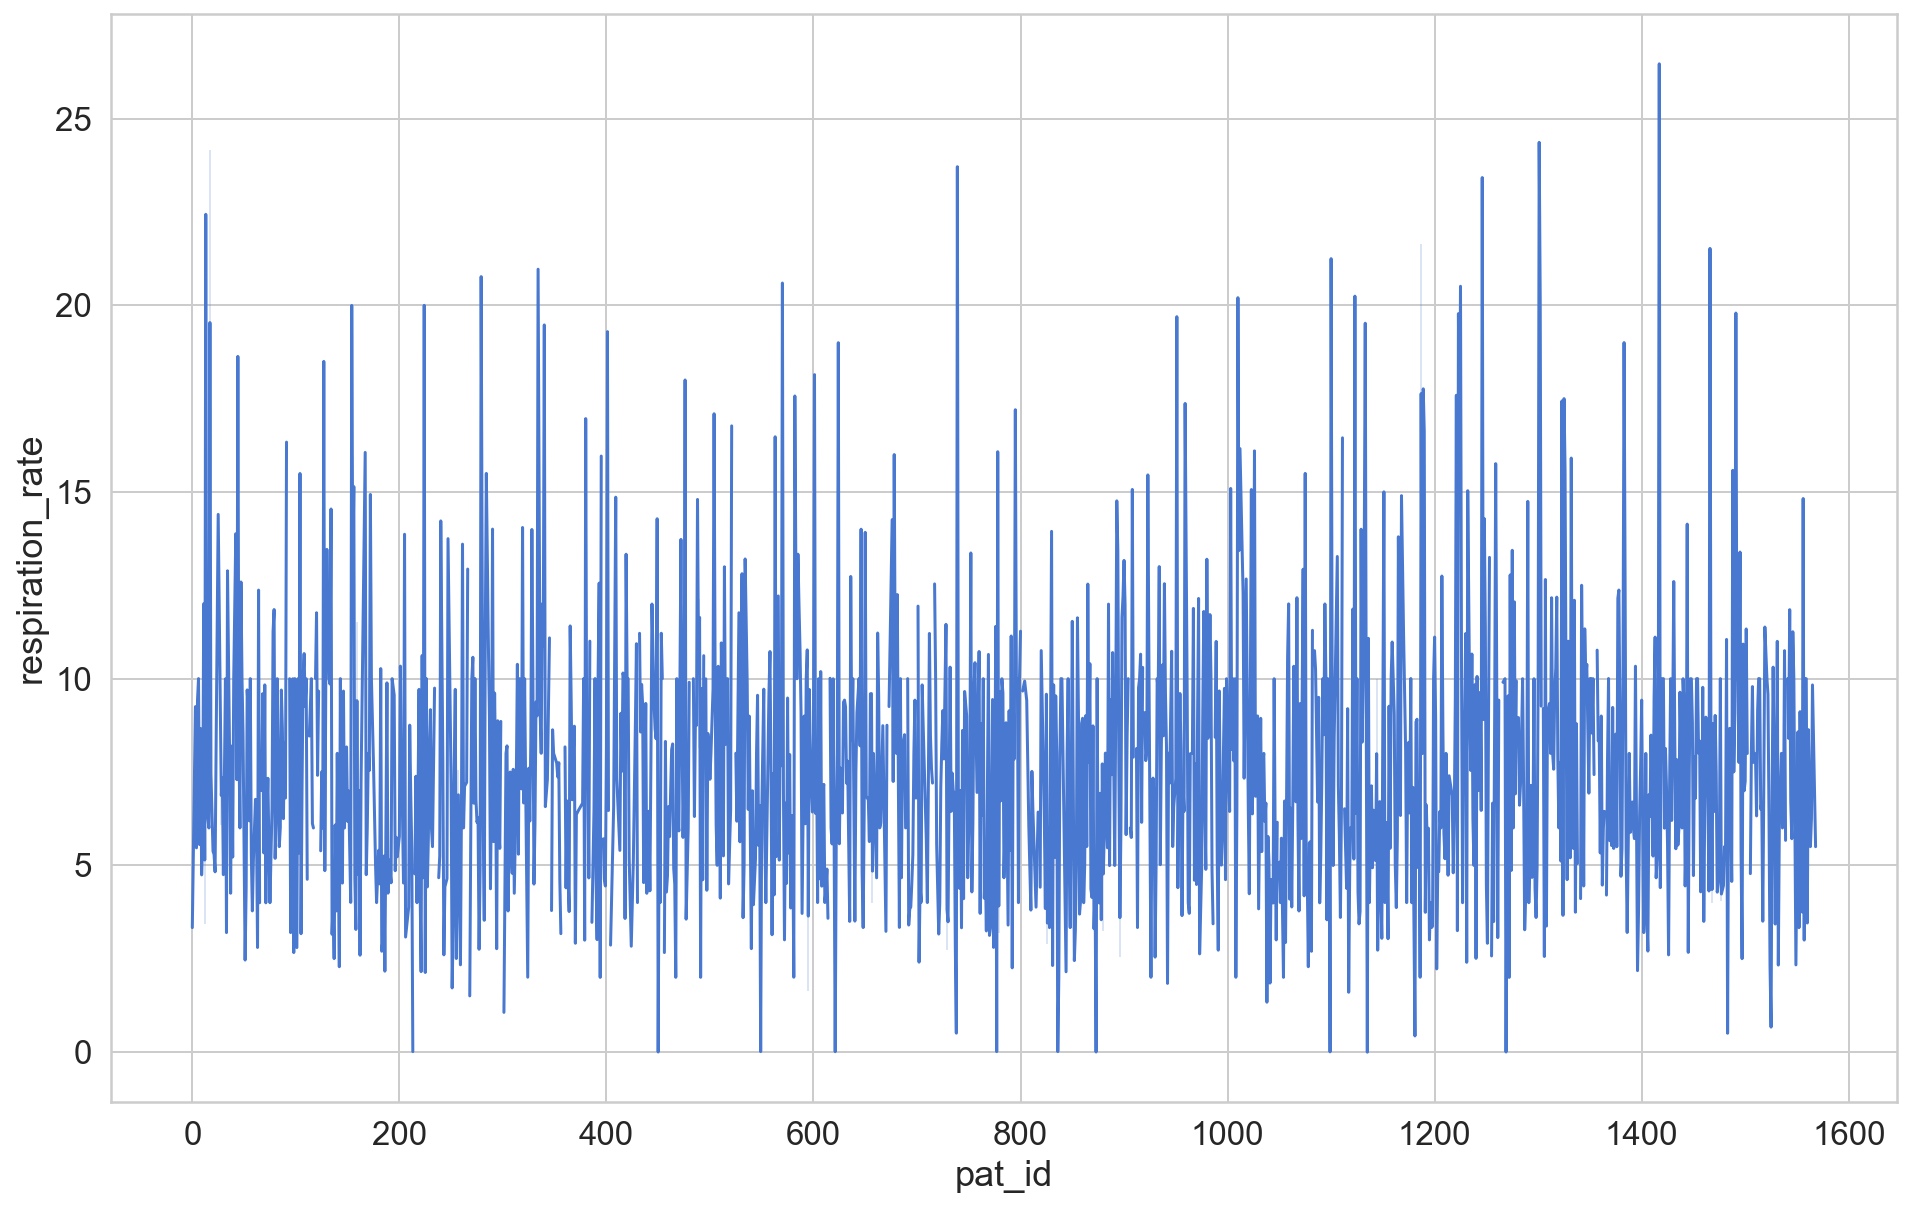

In [17]:
sns.lineplot(x='pat_id',y='respiration_rate', data=df_ts)

<AxesSubplot:xlabel='day', ylabel='respiration_rate'>

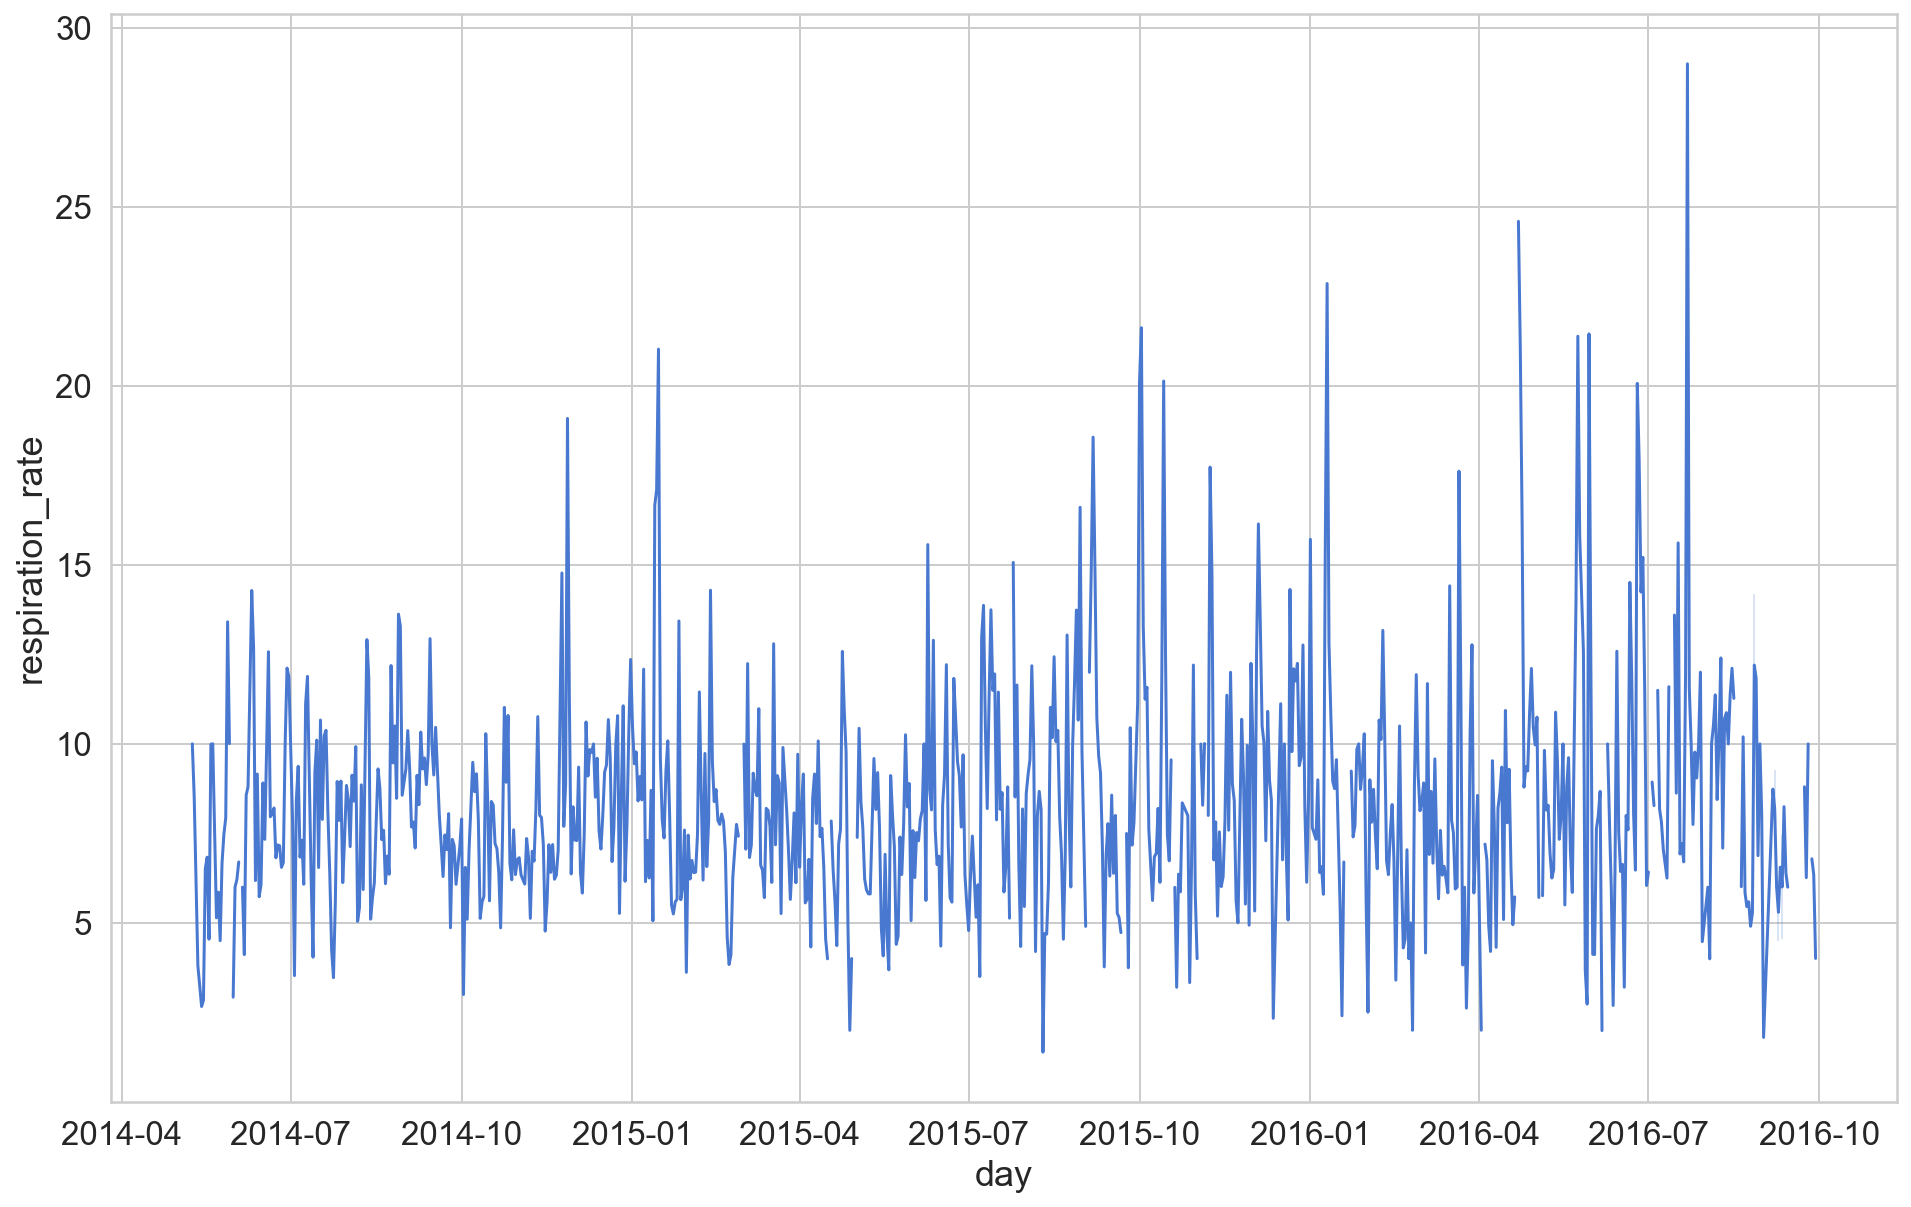

In [18]:
sns.lineplot(x='day',y='respiration_rate', data=df_ts)

<AxesSubplot:xlabel='day_w', ylabel='respiration_rate'>

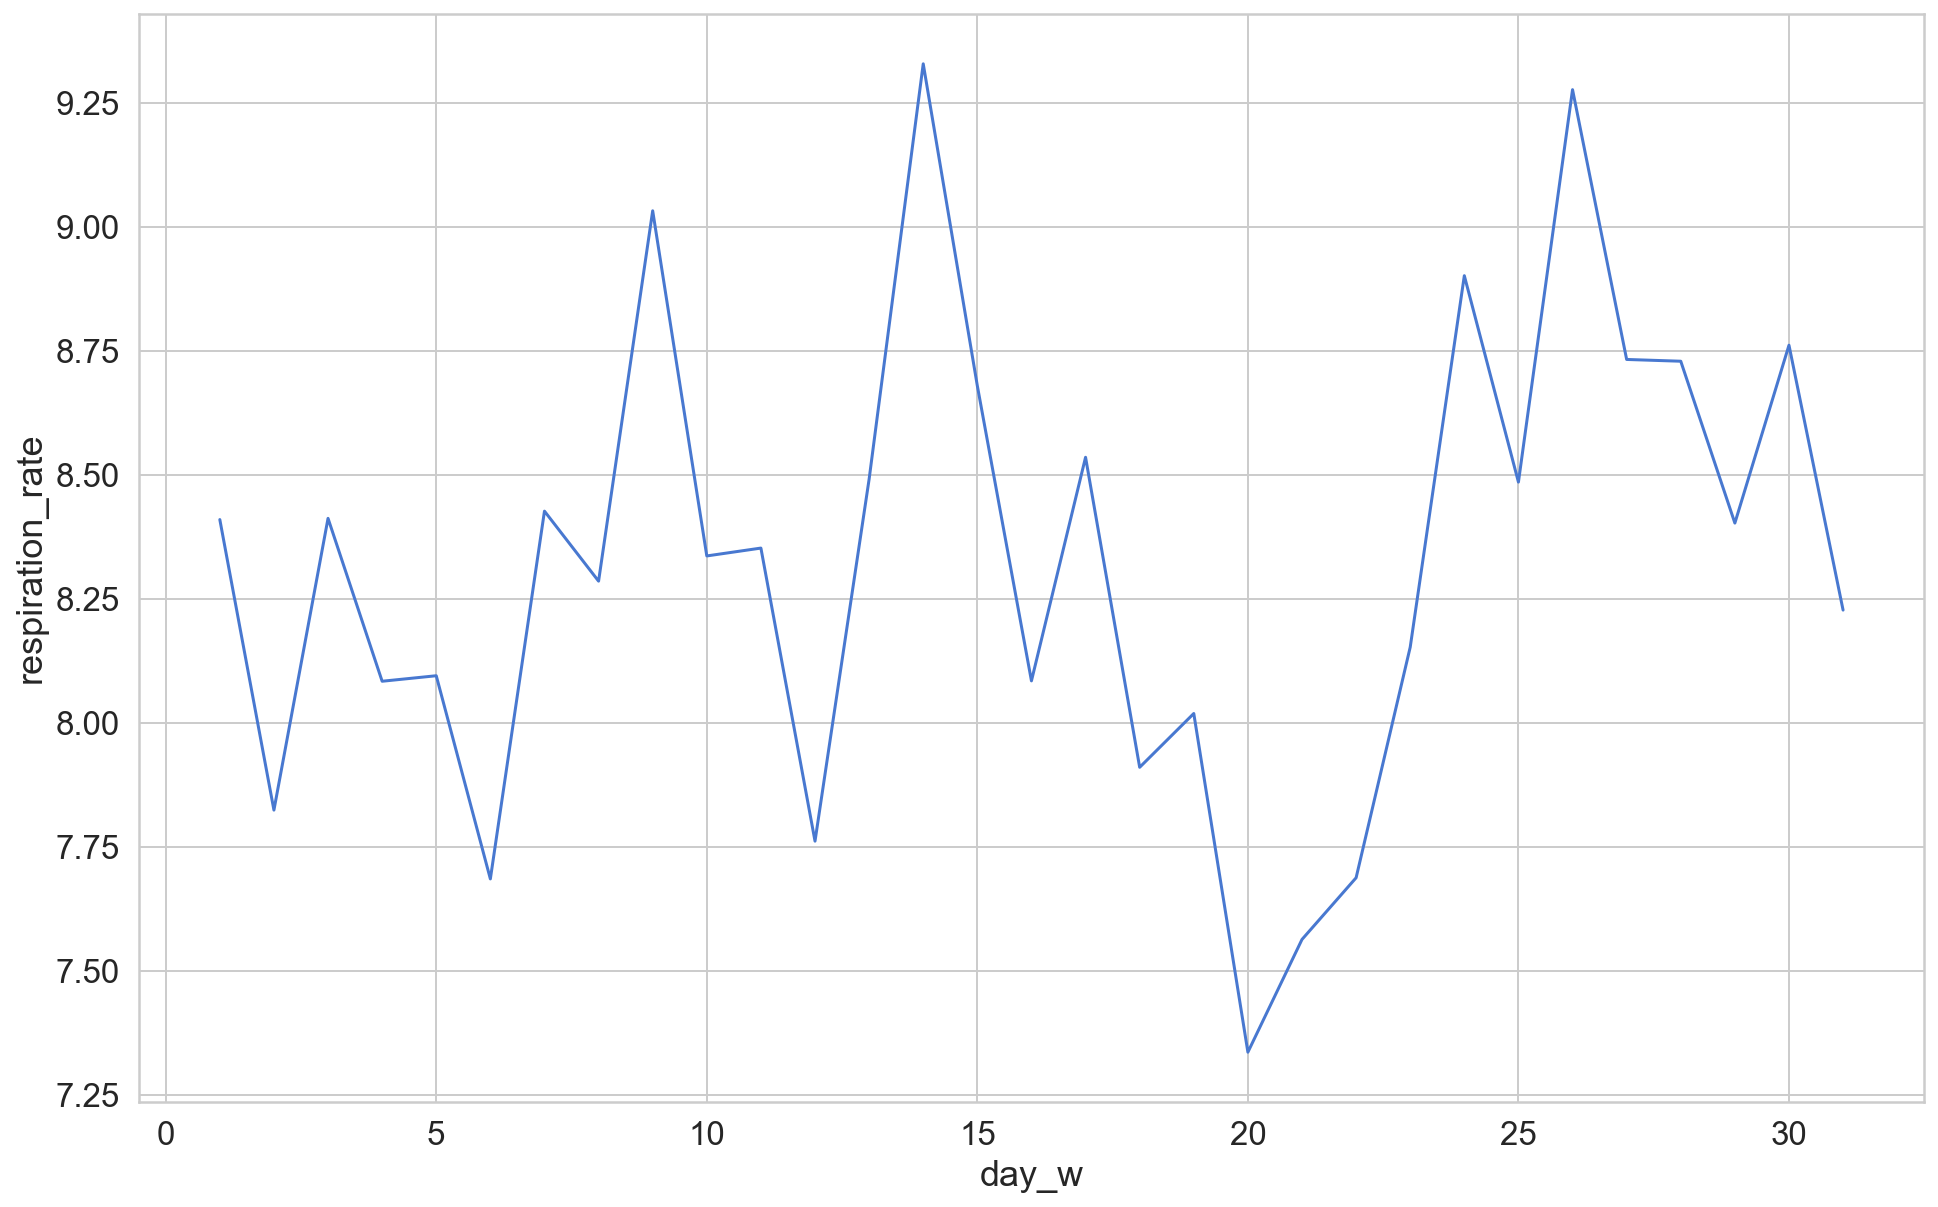

In [19]:
sns.lineplot(x='day_w',y='respiration_rate', data=df_ts)

<AxesSubplot:xlabel='blood_pressure', ylabel='duration'>

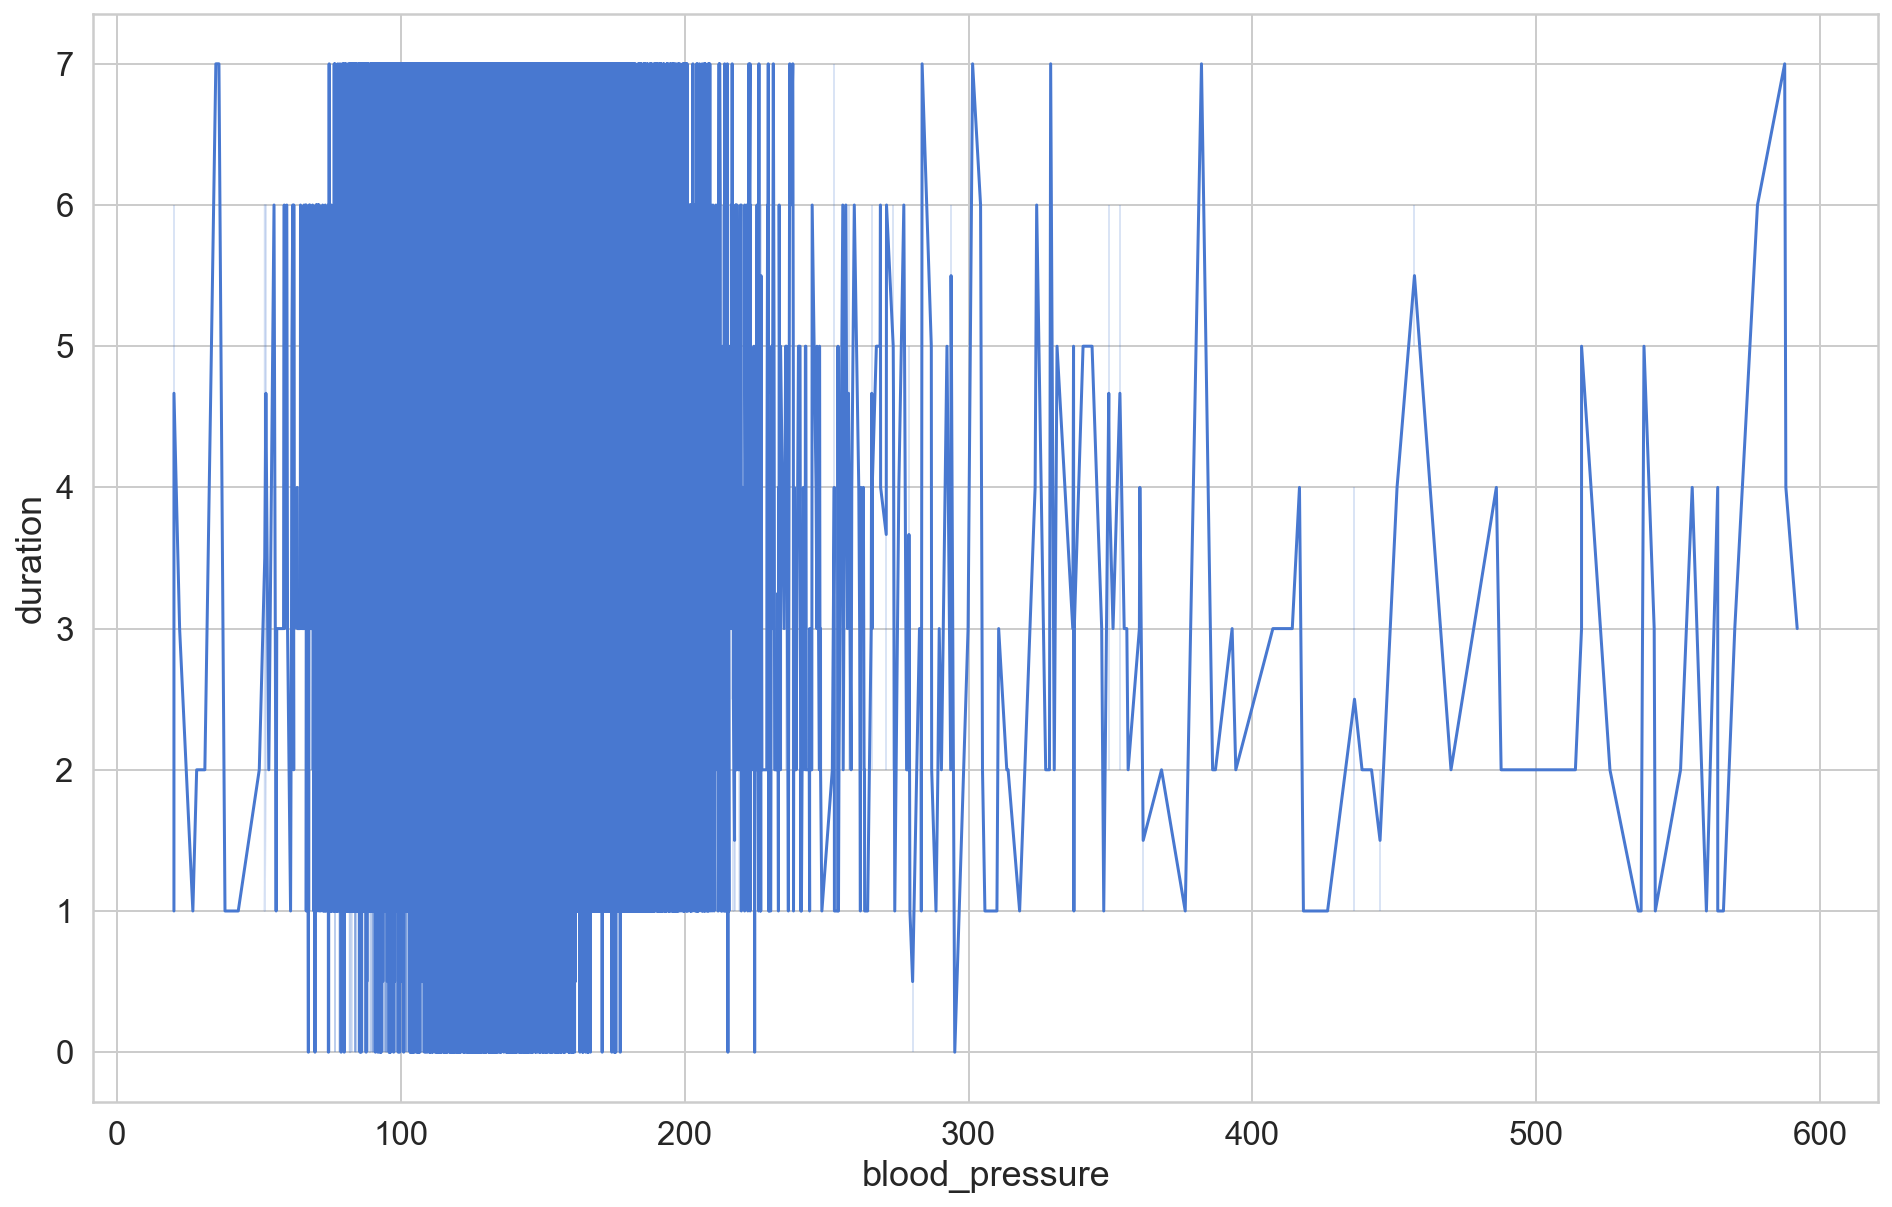

In [20]:
sns.lineplot(x='blood_pressure',y='duration', data=df_ts)

<AxesSubplot:xlabel='pat_id', ylabel='blood_pressure'>

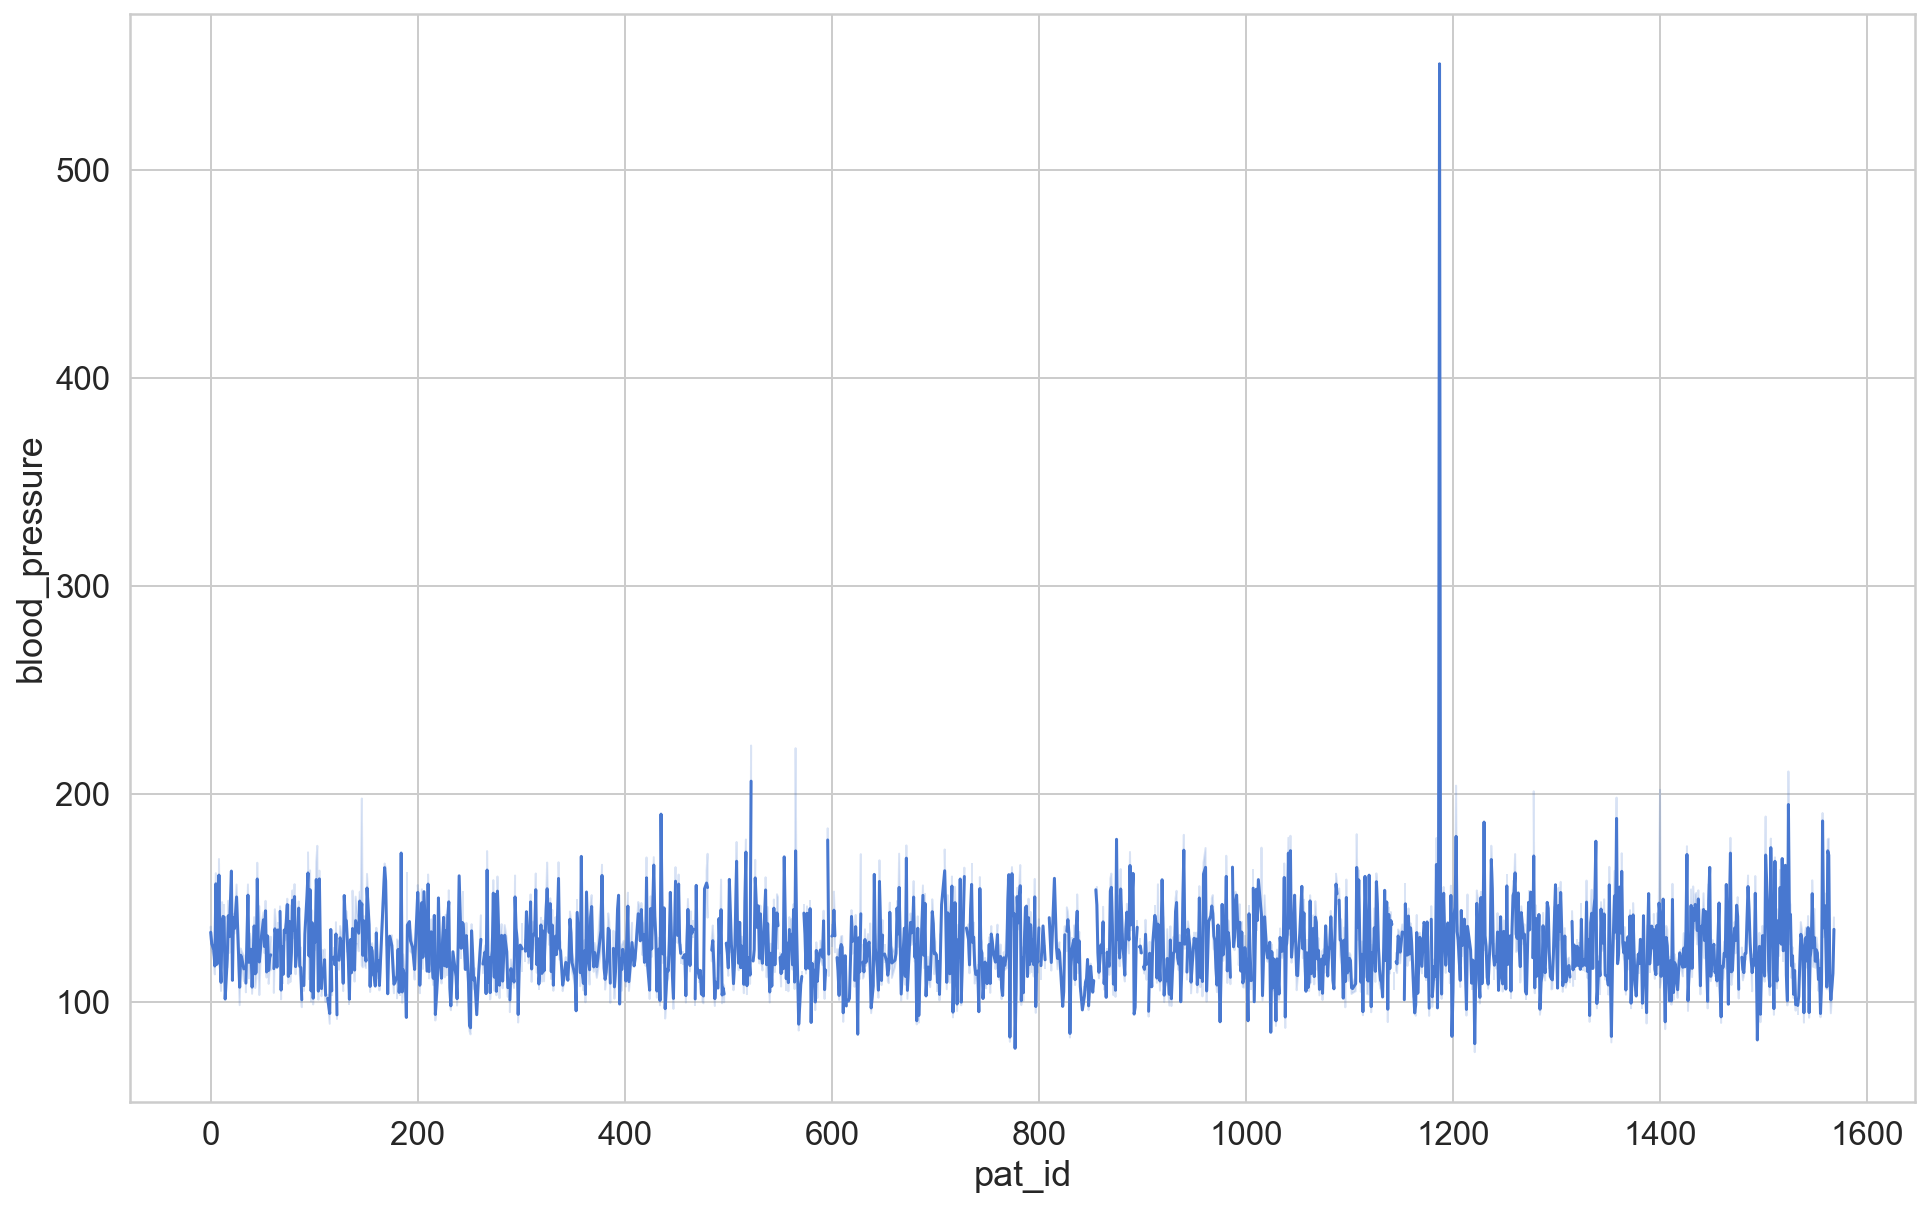

In [21]:
sns.lineplot(x='pat_id',y='blood_pressure', data=df_ts)

<AxesSubplot:xlabel='day', ylabel='blood_pressure'>

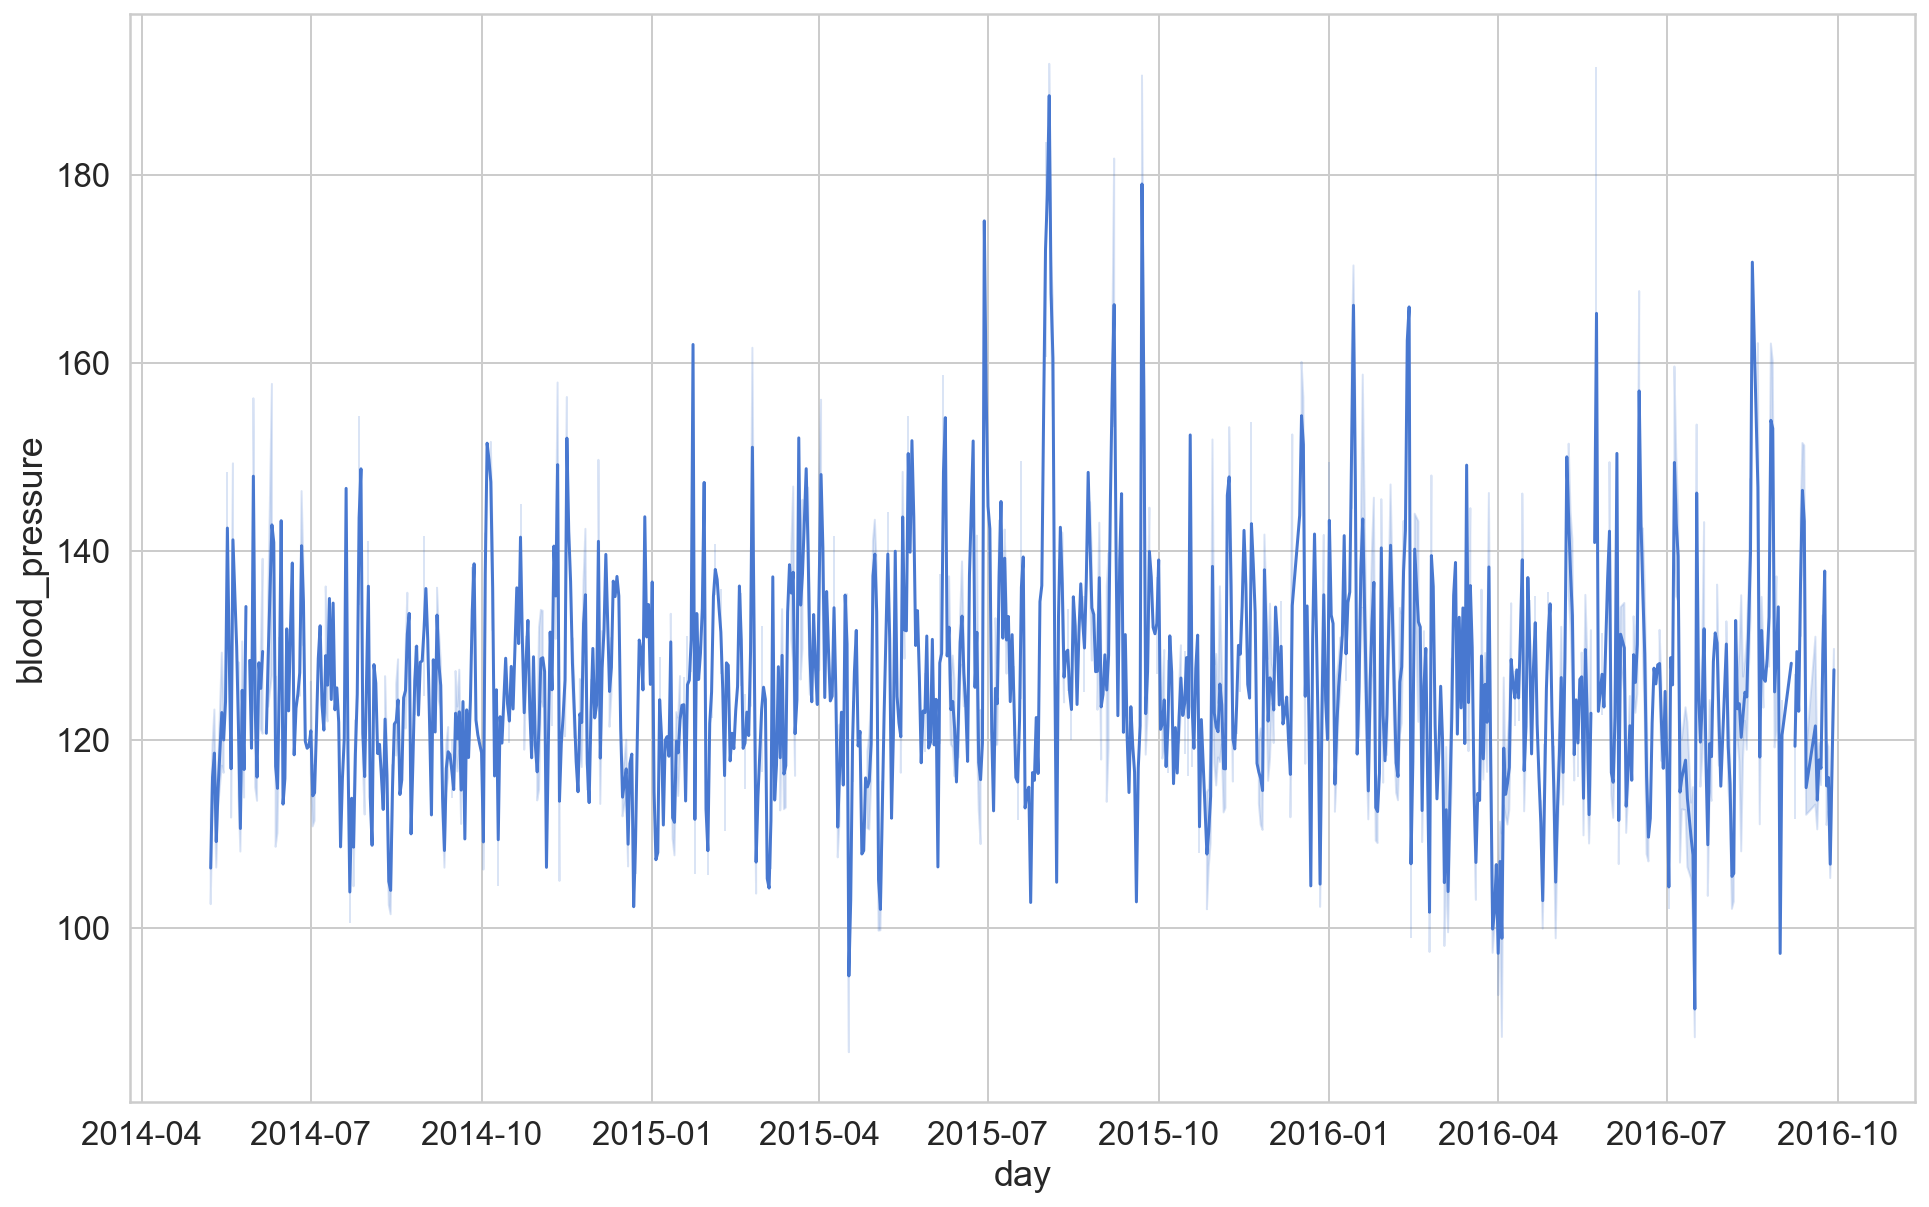

In [22]:
sns.lineplot(x='day',y='blood_pressure', data=df_ts)

<AxesSubplot:xlabel='day_w', ylabel='blood_pressure'>

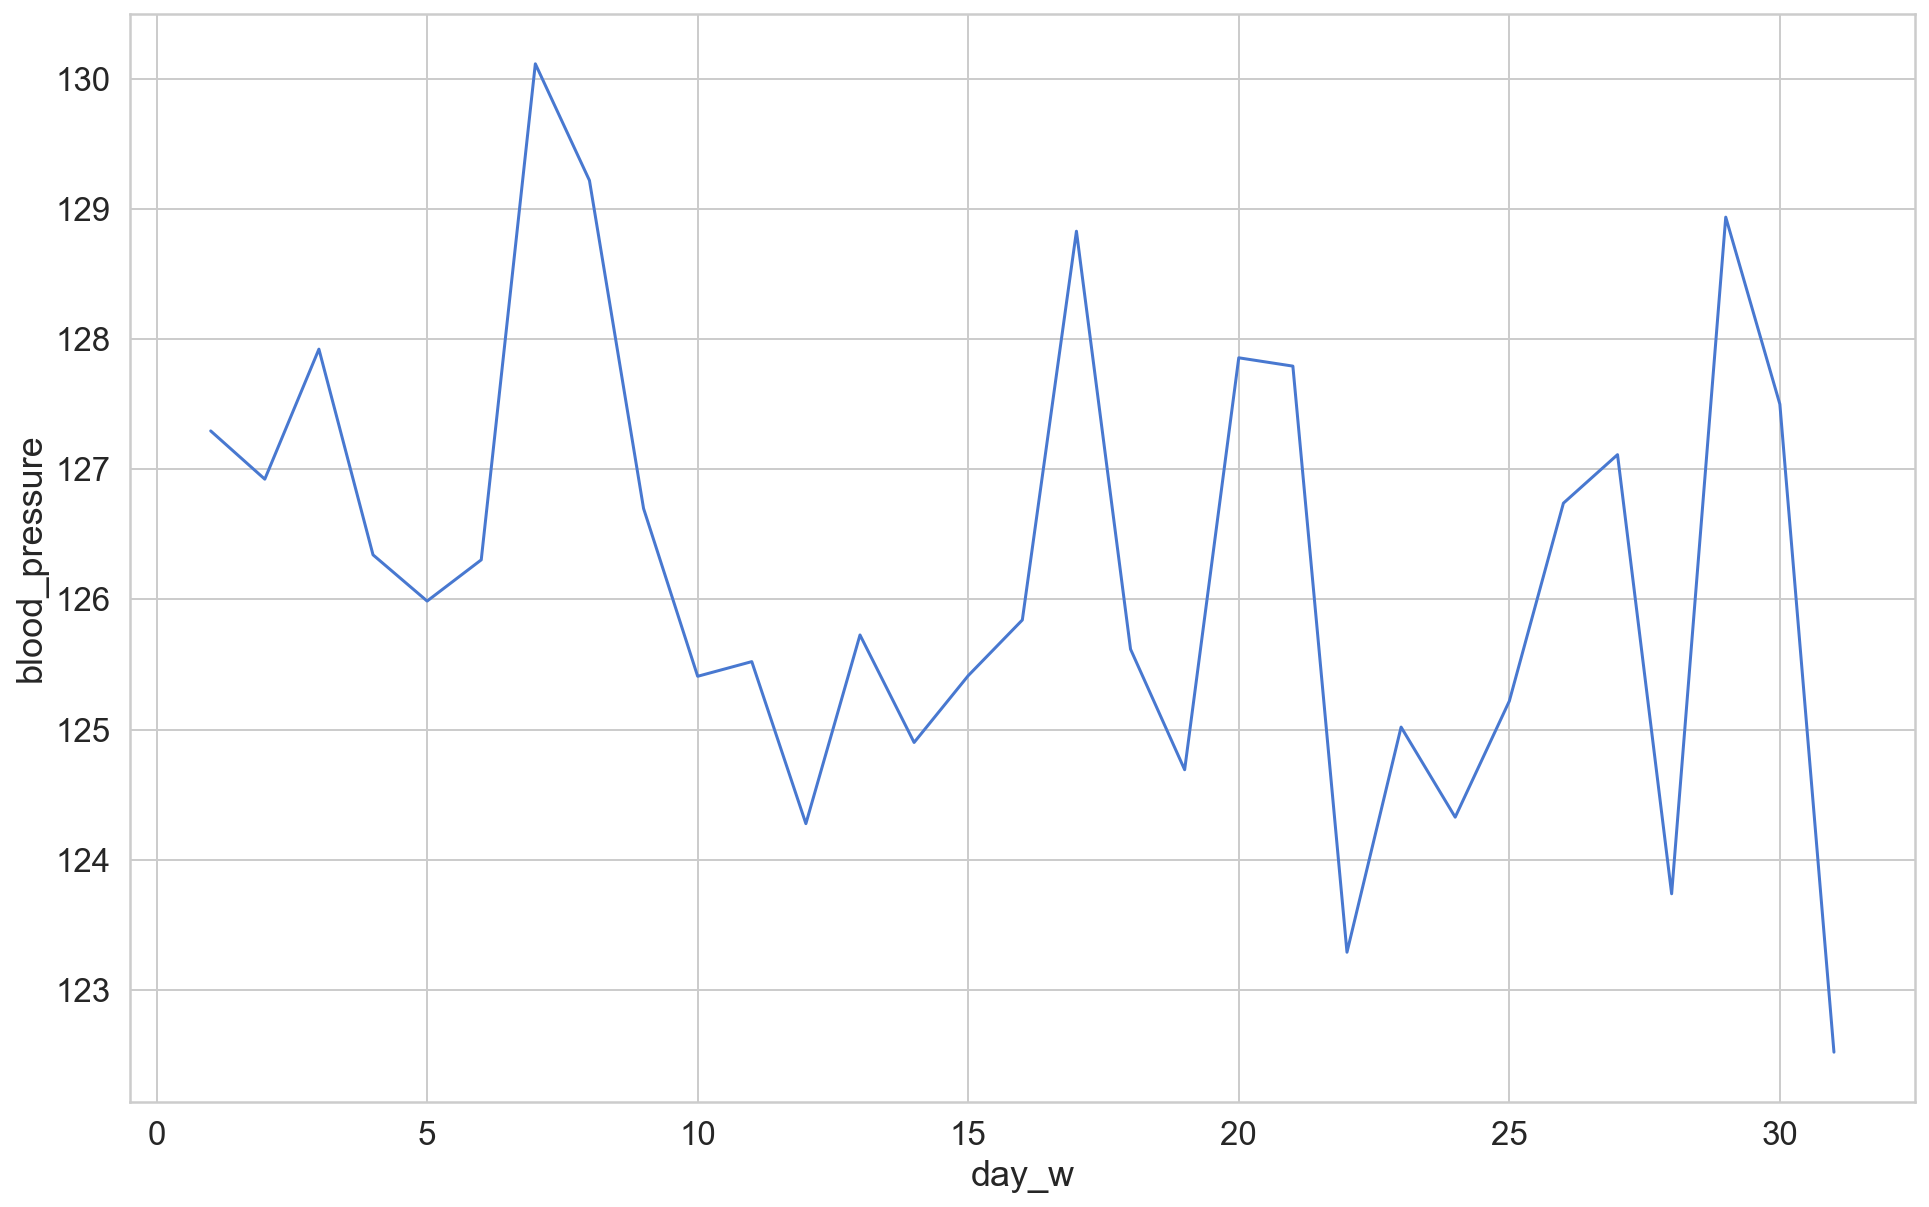

In [23]:
sns.lineplot(x='day_w',y='blood_pressure', data=df_ts)

In [24]:
df_ts = df_ts[df_ts['blood_pressure']<= 200]

In [35]:
df_ts['respiration_rate'].fillna(df_ts['respiration_rate'].mean(),inplace=True)
df_ts['temperature'].fillna(df_ts['temperature'].mean(),inplace=True)


In [36]:
df_ts.head()

parameter  pat_id   age date_admission date_discharge  duration        day  \
53394        1250  43.0     2014-05-08     2014-05-12       4.0 2014-05-08   
53395        1250  43.0     2014-05-08     2014-05-12       4.0 2014-05-08   
53396        1250  43.0     2014-05-08     2014-05-12       4.0 2014-05-08   
53397        1250  43.0     2014-05-08     2014-05-12       4.0 2014-05-08   
53398        1250  43.0     2014-05-08     2014-05-12       4.0 2014-05-08   

parameter  hour  blood_pressure  respiration_rate  temperature  day_w  month  \
53394      19.0      105.329998          8.434698    37.324037      8      5   
53395      20.0      120.594739          8.434698    37.324037      8      5   
53396      21.0      104.233168          8.434698    37.324037      8      5   
53397      22.0      100.833336          8.434698    37.324037      8      5   
53398      23.0      100.881866          8.434698    37.324037      8      5   

parameter  year  
53394      2014  
53395      2014  
53396      2014  
53397      2014  
53398      2014

<AxesSubplot:xlabel='day', ylabel='temperature'>

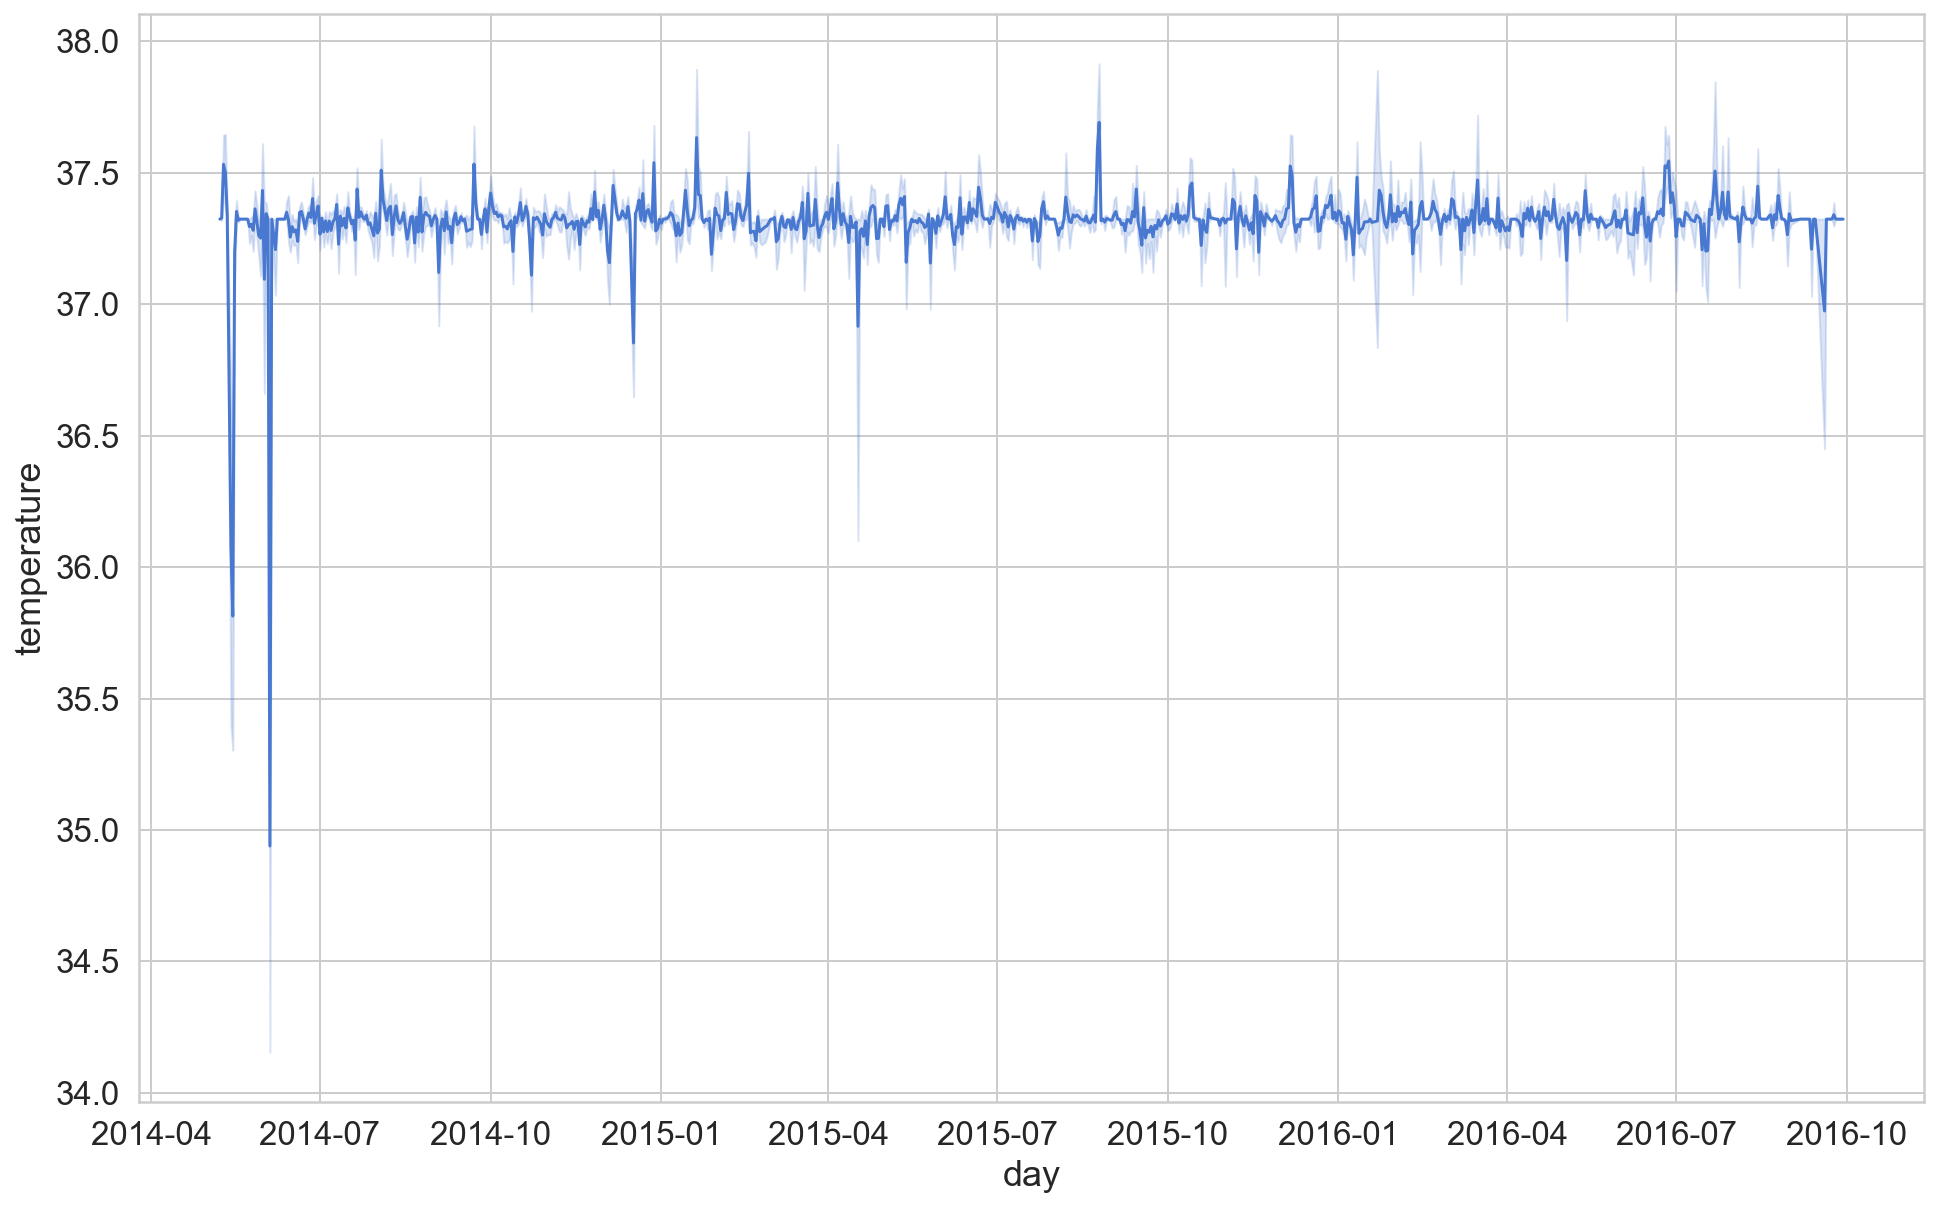

In [37]:
sns.lineplot(x='day',y='temperature', data=df_ts)

<AxesSubplot:xlabel='day', ylabel='respiration_rate'>

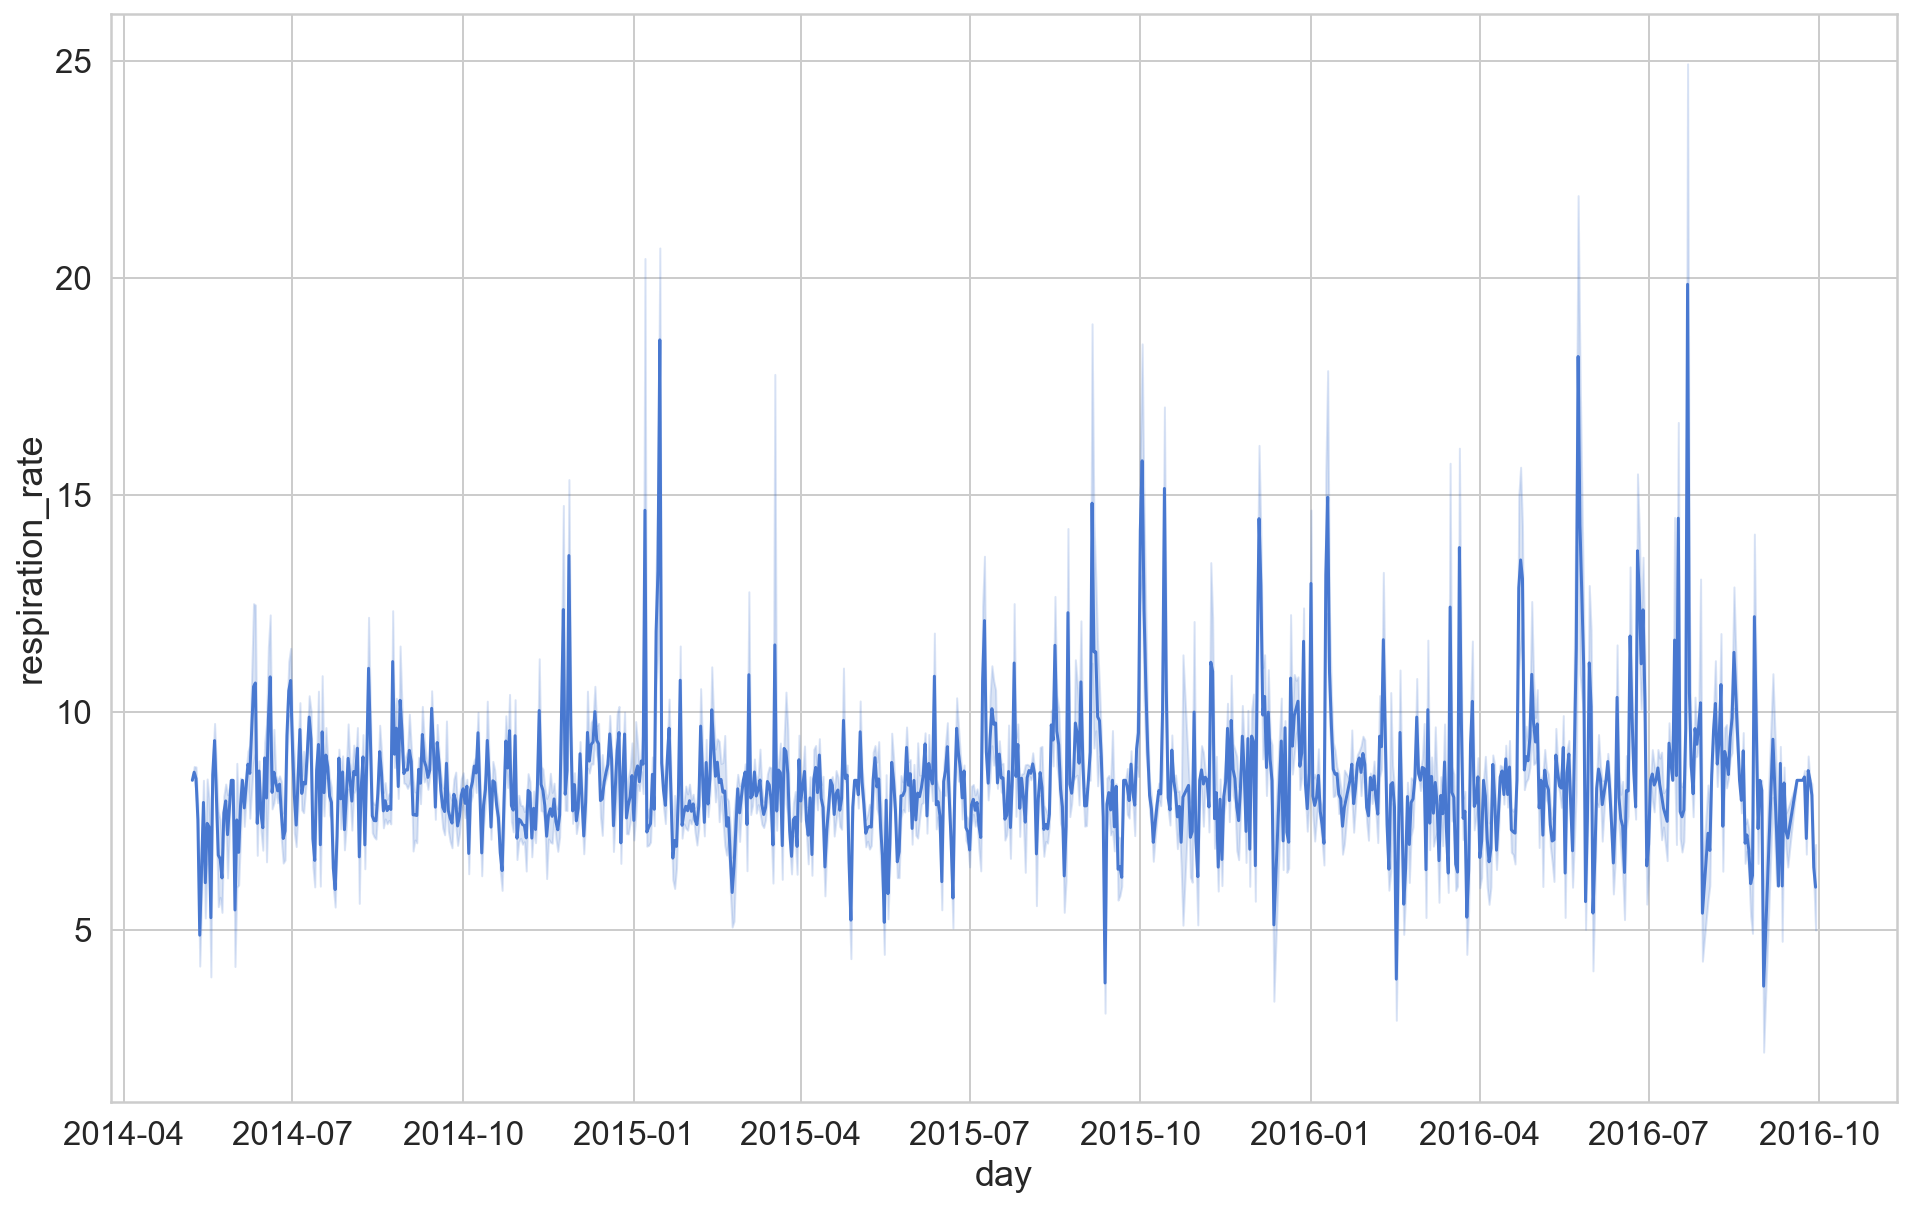

In [38]:
sns.lineplot(x='day',y='respiration_rate', data=df_ts)

<AxesSubplot:xlabel='day', ylabel='duration'>

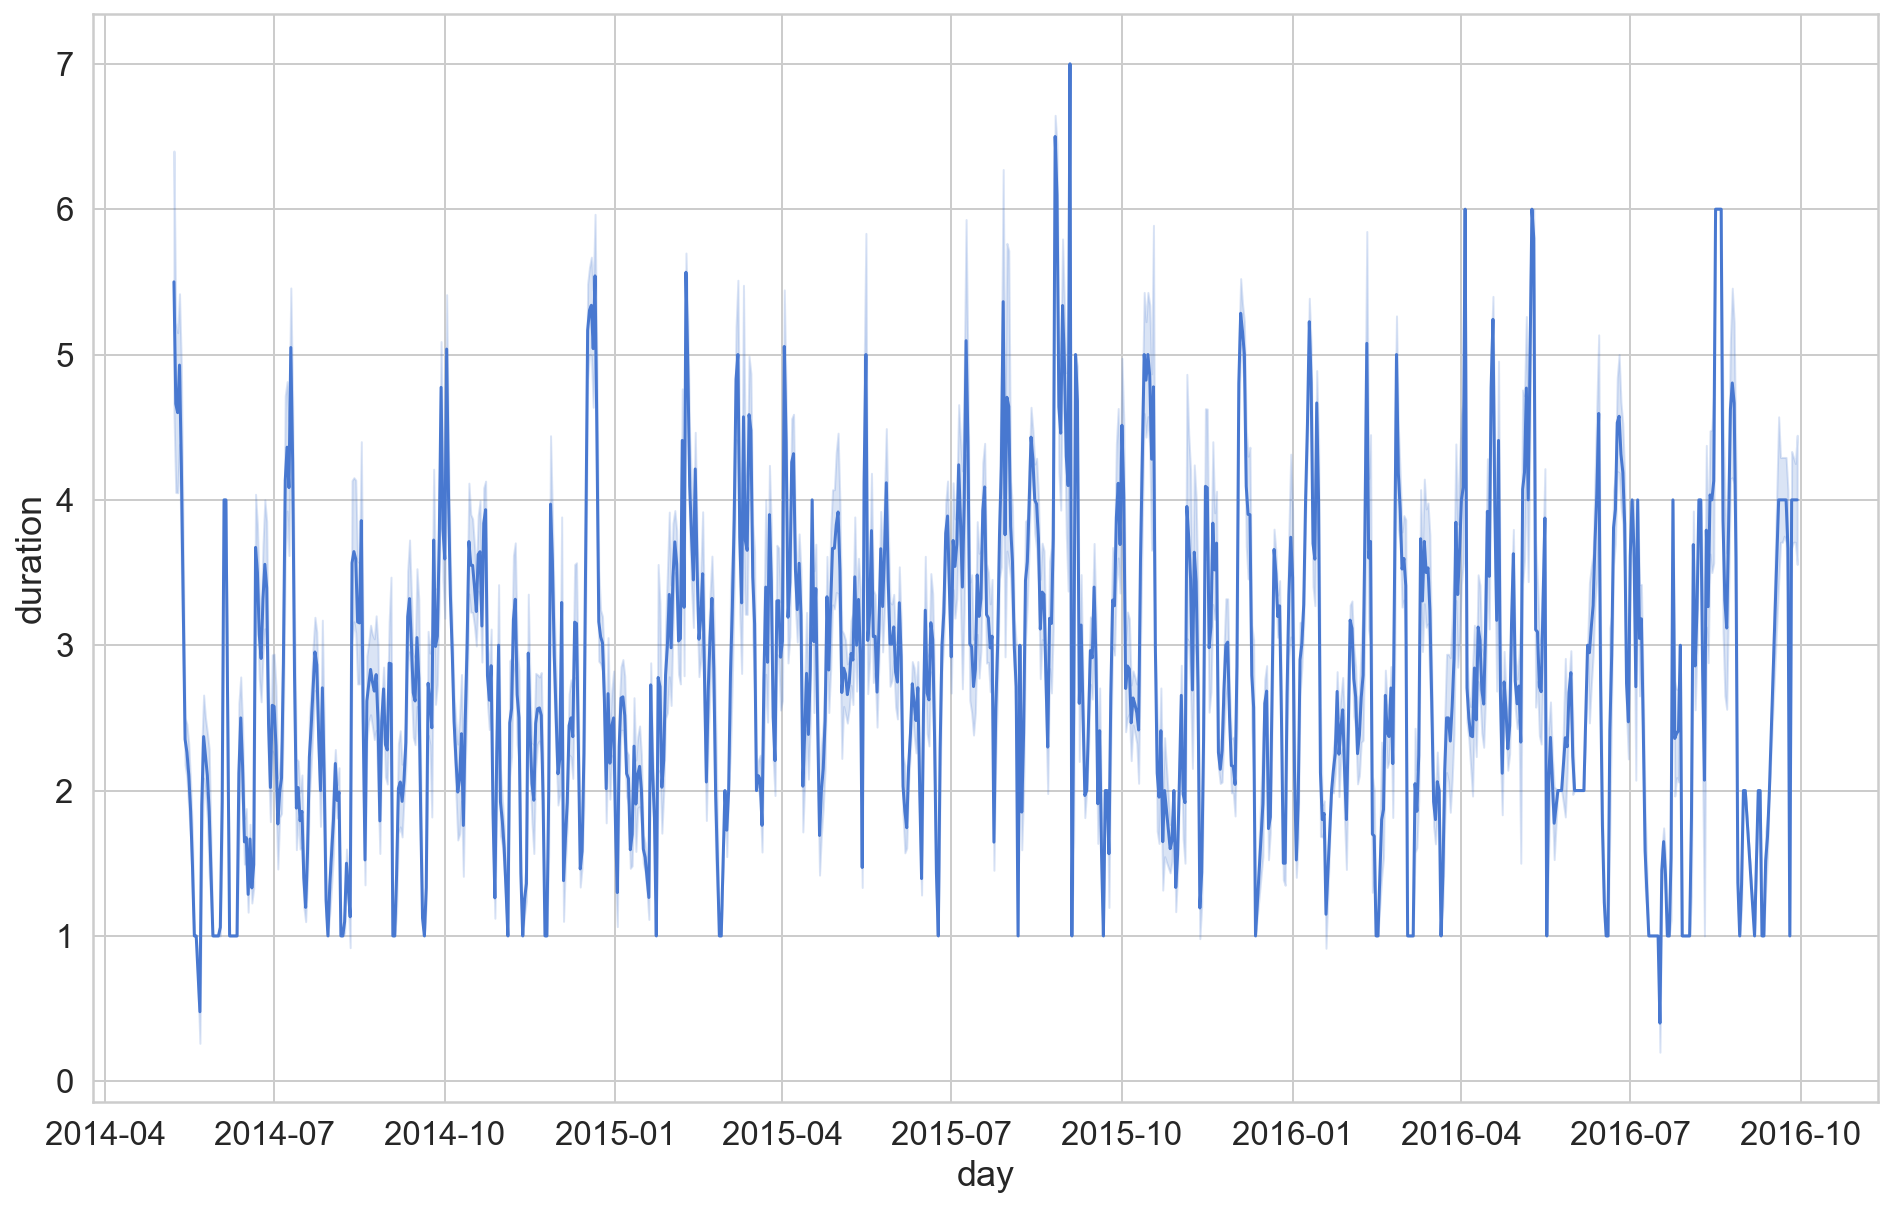

In [40]:
sns.lineplot(x='day',y='duration', data=df_ts)

<AxesSubplot:xlabel='pat_id', ylabel='blood_pressure'>

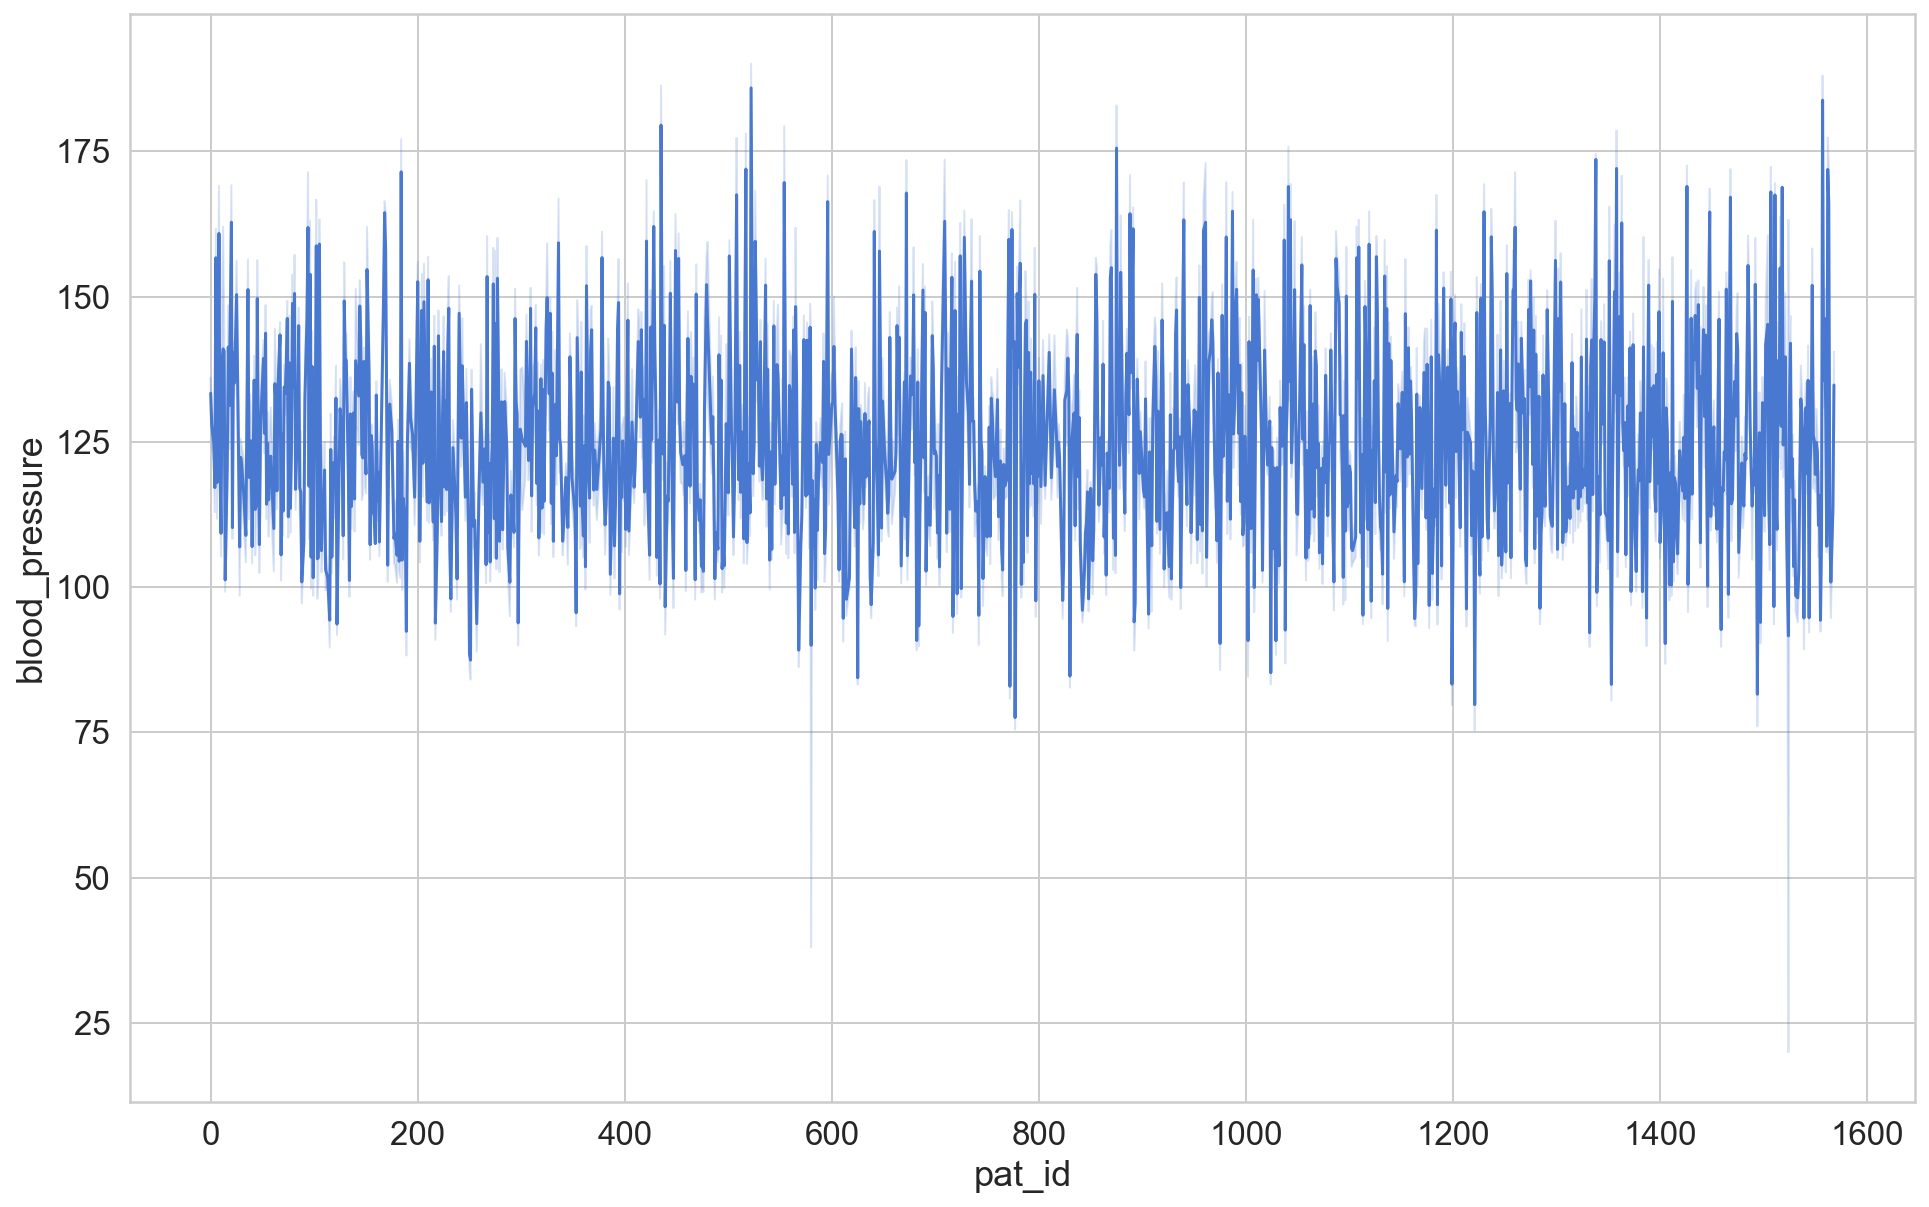

In [25]:
sns.lineplot(x='pat_id',y='blood_pressure', data=df_ts)

In [39]:
df_ts.shape

(68011, 13)

In [46]:
df = df_ts[['duration','age','blood_pressure','respiration_rate','temperature','day_w','month','year']]
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

61209 6802


In [49]:
df.head()

parameter  duration   age  blood_pressure  respiration_rate  temperature  \
53394           4.0  43.0      105.329998          8.434698    37.324037   
53395           4.0  43.0      120.594739          8.434698    37.324037   
53396           4.0  43.0      104.233168          8.434698    37.324037   
53397           4.0  43.0      100.833336          8.434698    37.324037   
53398           4.0  43.0      100.881866          8.434698    37.324037   

parameter  day_w  month  year  
53394          8      5  2014  
53395          8      5  2014  
53396          8      5  2014  
53397          8      5  2014  
53398          8      5  2014

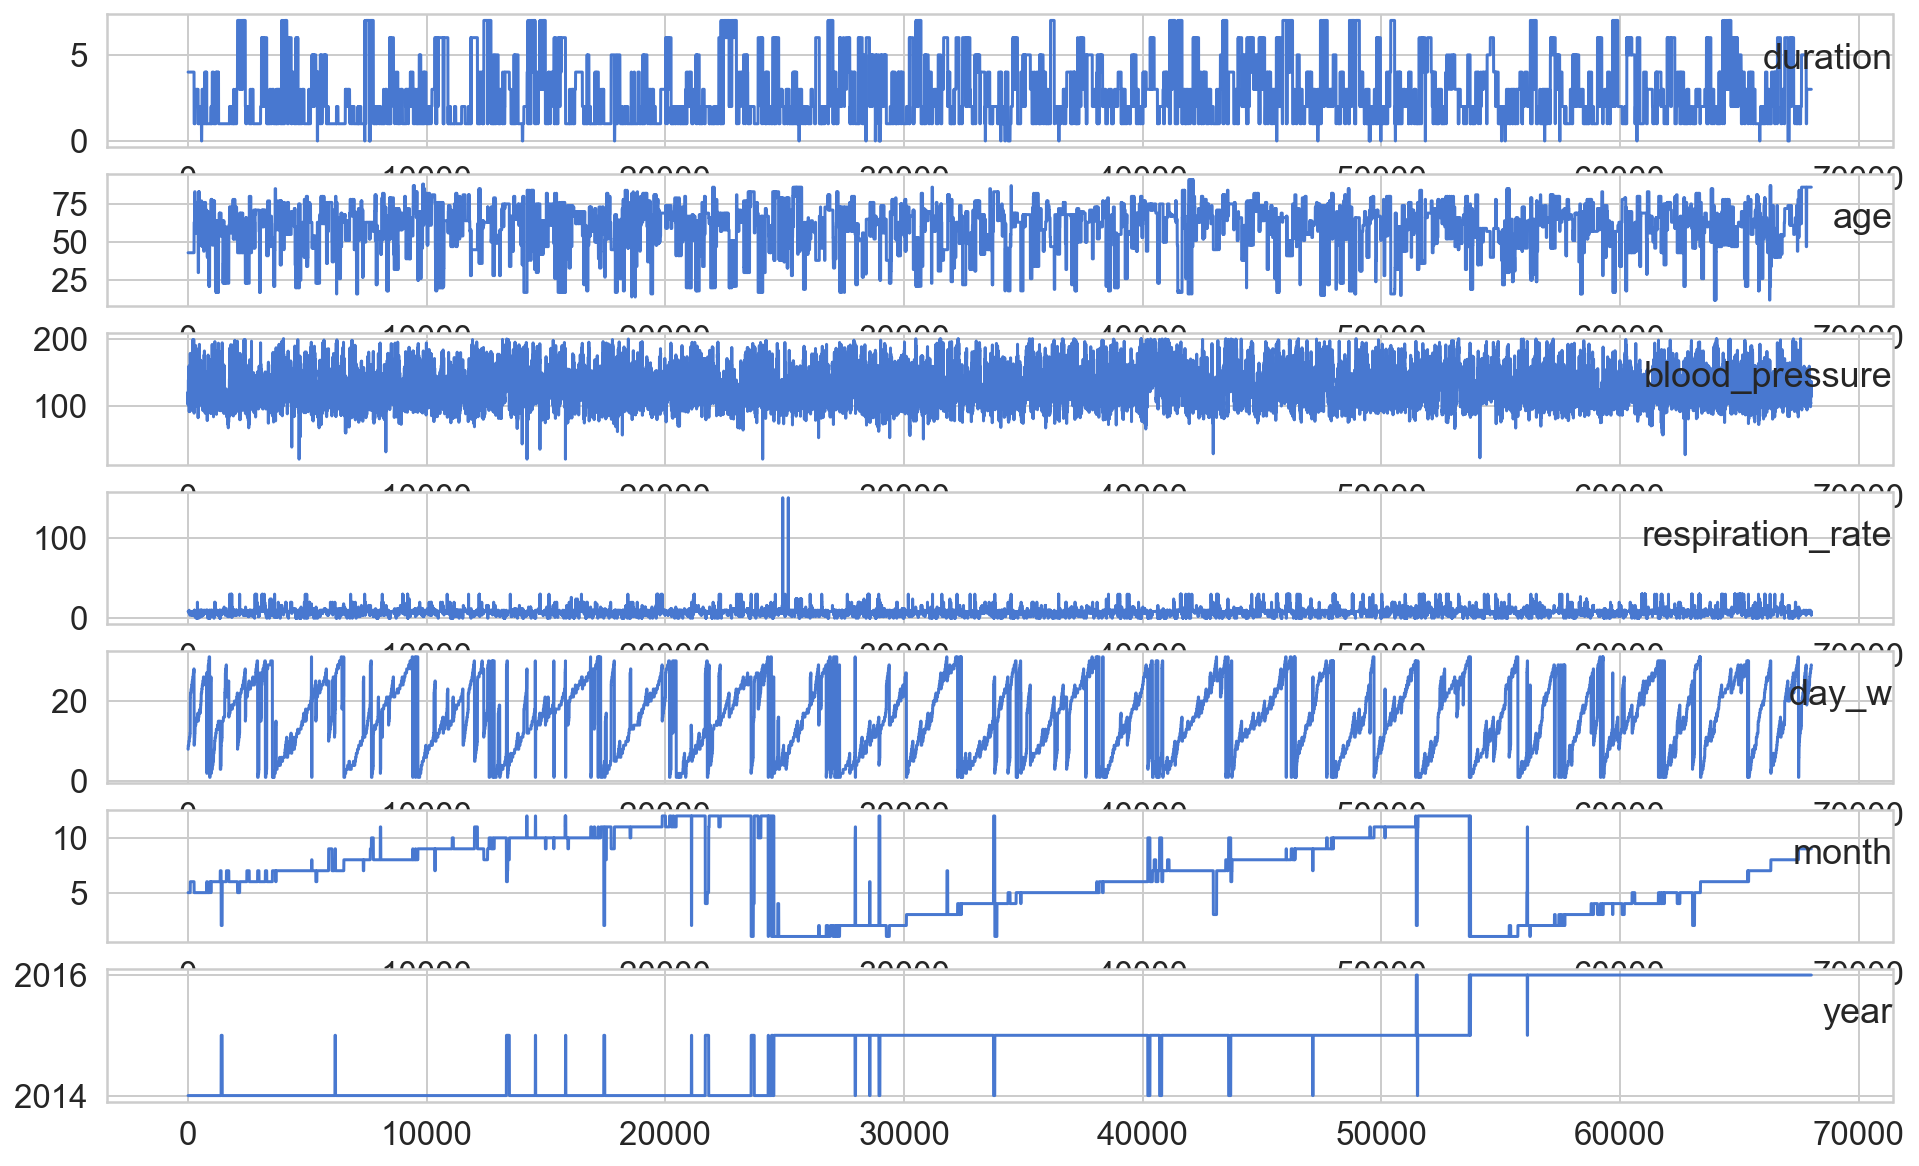

In [52]:
from matplotlib import pyplot
dataset = df
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [47]:
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [57]:
dataset = df
values = dataset.values
values[0]

array([   4.        ,   43.        ,  105.3299982 ,    8.43469845,
         37.32403671,    8.        ,    5.        , 2014.        ])

In [59]:
# load dataset

# integer encode direction
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.571429   0.392405   0.474059   0.056298   0.610104   0.233333   
2   0.571429   0.392405   0.558864   0.056298   0.610104   0.233333   
3   0.571429   0.392405   0.467965   0.056298   0.610104   0.233333   
4   0.571429   0.392405   0.449077   0.056298   0.610104   0.233333   
5   0.571429   0.392405   0.449347   0.056298   0.610104   0.233333   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.363636        0.0  0.571429  
2   0.363636        0.0  0.571429  
3   0.363636        0.0  0.571429  
4   0.363636        0.0  0.571429  
5   0.363636        0.0  0.571429  


In [60]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(8760, 1, 8) (8760,) (59250, 1, 8) (59250,)


Epoch 1/50
122/122 - 2s - loss: 0.1993 - val_loss: 0.1914
Epoch 2/50
122/122 - 2s - loss: 0.1334 - val_loss: 0.1028
Epoch 3/50
122/122 - 2s - loss: 0.0480 - val_loss: 0.0610
Epoch 4/50
122/122 - 1s - loss: 0.0235 - val_loss: 0.0453
Epoch 5/50
122/122 - 2s - loss: 0.0209 - val_loss: 0.0330
Epoch 6/50
122/122 - 2s - loss: 0.0193 - val_loss: 0.0246
Epoch 7/50
122/122 - 2s - loss: 0.0179 - val_loss: 0.0292
Epoch 8/50
122/122 - 2s - loss: 0.0204 - val_loss: 0.0316
Epoch 9/50
122/122 - 2s - loss: 0.0170 - val_loss: 0.0234
Epoch 10/50
122/122 - 2s - loss: 0.0162 - val_loss: 0.0312
Epoch 11/50
122/122 - 2s - loss: 0.0161 - val_loss: 0.0283
Epoch 12/50
122/122 - 2s - loss: 0.0195 - val_loss: 0.0247
Epoch 13/50
122/122 - 2s - loss: 0.0152 - val_loss: 0.0288
Epoch 14/50
122/122 - 2s - loss: 0.0154 - val_loss: 0.0220
Epoch 15/50
122/122 - 2s - loss: 0.0155 - val_loss: 0.0275
Epoch 16/50
122/122 - 2s - loss: 0.0168 - val_loss: 0.0314
Epoch 17/50
122/122 - 2s - loss: 0.0148 - val_loss: 0.0223
Epoch 

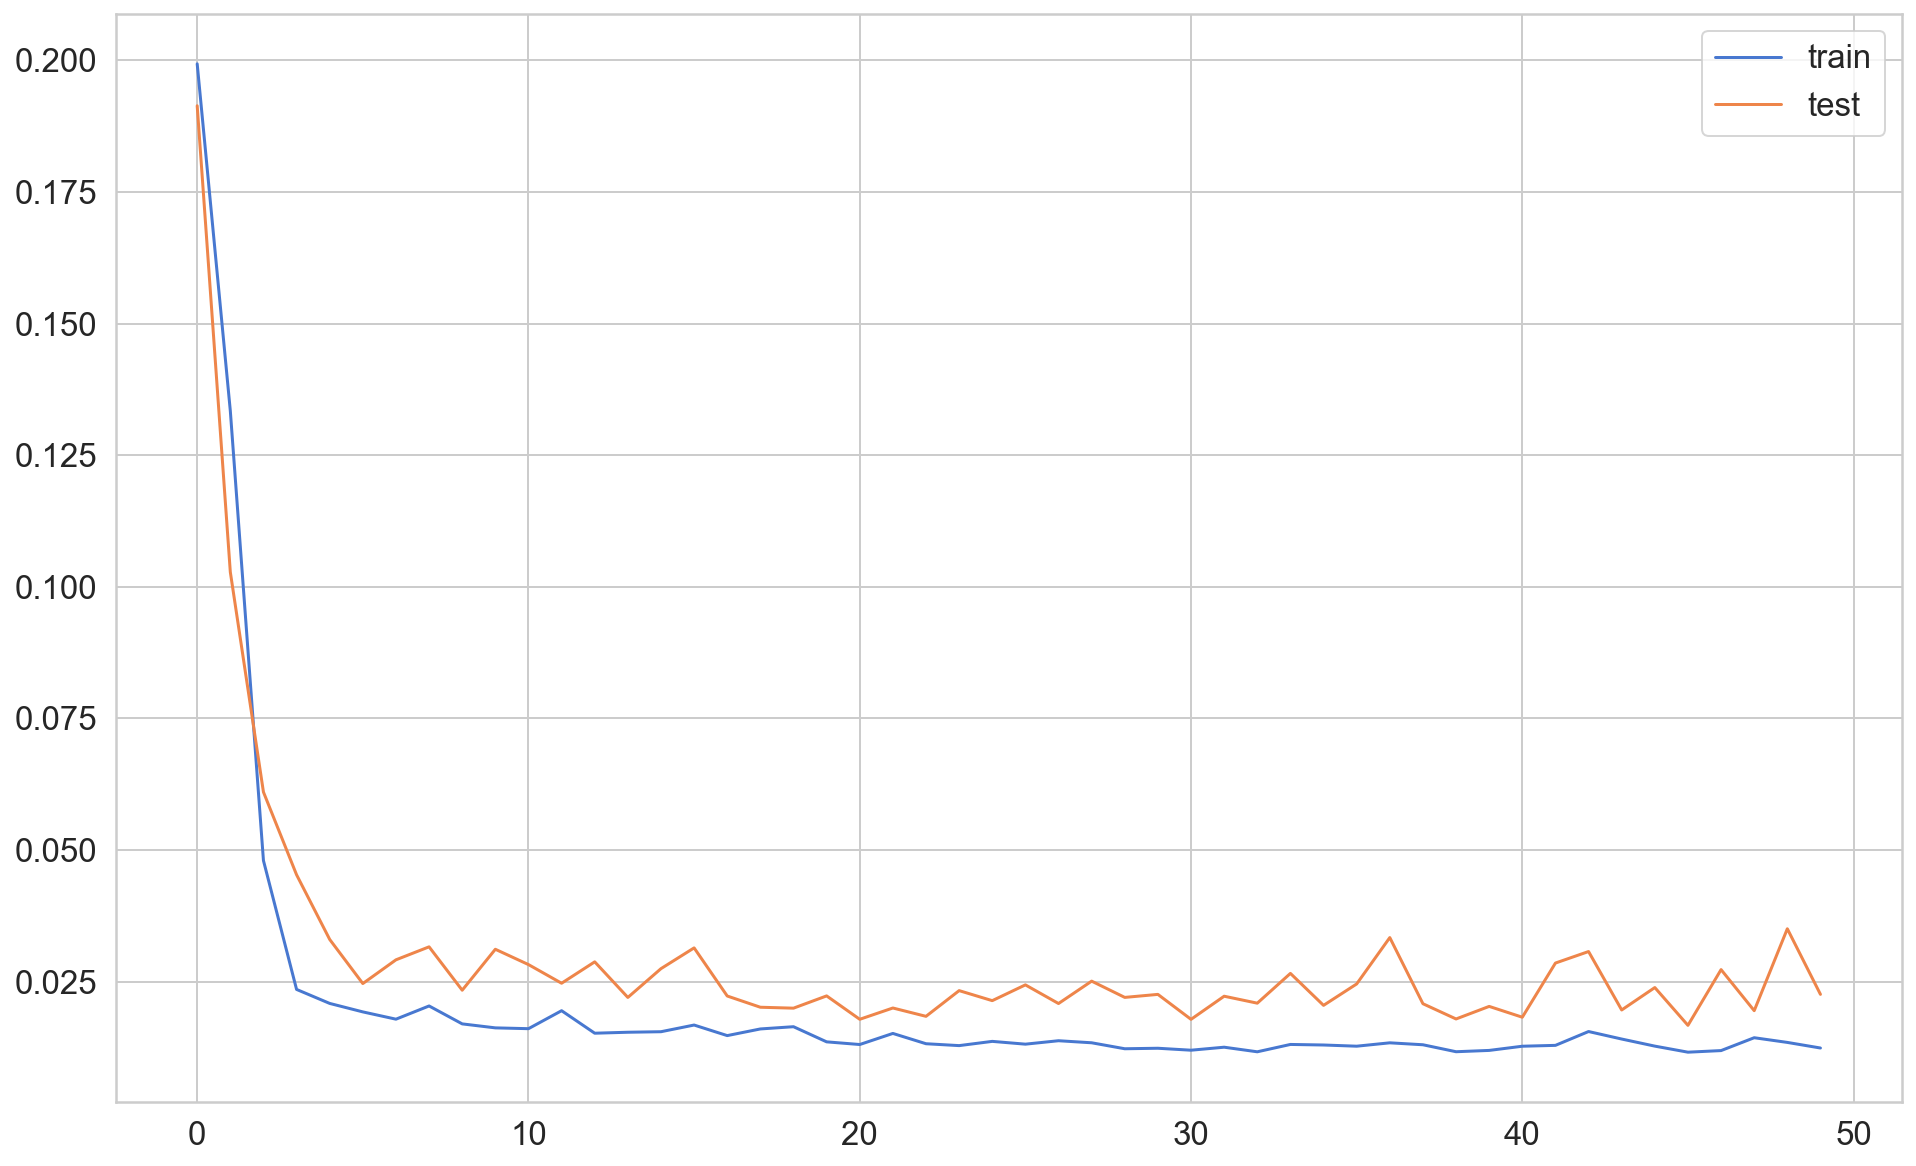

In [64]:
model = keras.Sequential()
model.add(keras.layers.LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(keras.layers.Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [81]:
from numpy import concatenate
from math import sqrt
from sklearn.metrics import mean_squared_error
# make a prediction
test_X = test_X.reshape((test_X.shape[0],1, 8))
train_X = train_X.reshape((train_X.shape[0],1, 8))
yhat = model.predict(test_X)
yhat_train = model.predict(train_X)

test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

inv_yhat_train = concatenate((yhat_train, train_X[:, 1:]), axis=1)
inv_yhat_train = scaler.inverse_transform(inv_yhat_train)
inv_yhat_train = inv_yhat_train[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

train_y = train_y.reshape((len(train_y), 1))
inv_y_t = concatenate((train_y, train_X[:, 1:]), axis=1)
inv_y_t = scaler.inverse_transform(inv_y_t)
inv_y_t = inv_y_t[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.482


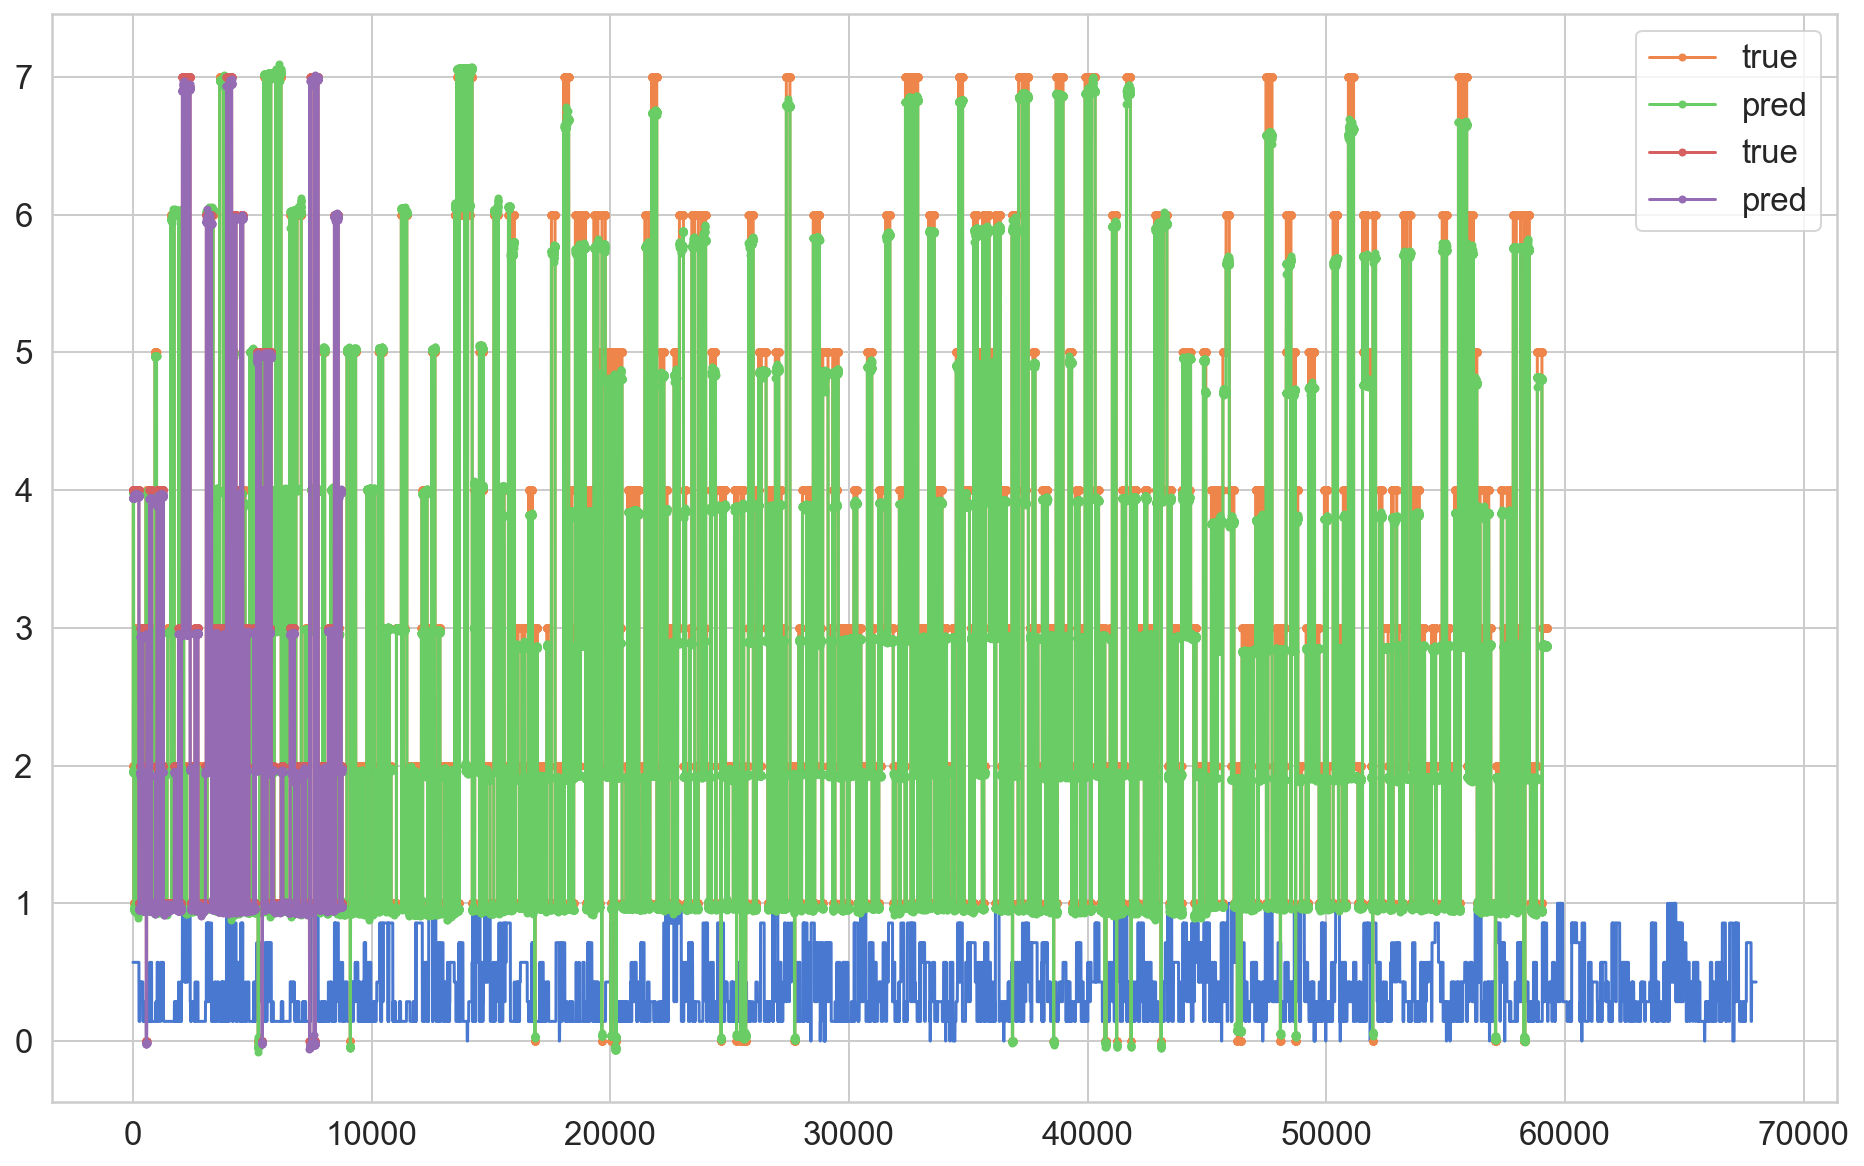

In [85]:
plt.plot(scaled[:, 0])
plt.plot(inv_y.flatten(),marker = '.',label ='true')
plt.plot(inv_yhat.flatten(),marker = '.',label ='pred')
plt.plot(inv_y_t.flatten(),marker = '.',label ='true')
plt.plot(inv_yhat_train.flatten(),marker = '.',label ='pred')
plt.legend()

In [80]:
train

array([[0.5714286 , 0.3924051 , 0.47405905, ..., 0.36363637, 0.        ,
        0.5714286 ],
       [0.5714286 , 0.3924051 , 0.55886376, ..., 0.36363637, 0.        ,
        0.5714286 ],
       [0.5714286 , 0.3924051 , 0.46796548, ..., 0.36363637, 0.        ,
        0.5714286 ],
       ...,
       [0.14285715, 0.34177217, 0.41592526, ..., 0.6363636 , 0.        ,
        0.14285715],
       [0.14285715, 0.34177217, 0.39135718, ..., 0.6363636 , 0.        ,
        0.2857143 ],
       [0.2857143 , 0.7594937 , 0.75154185, ..., 0.6363636 , 0.        ,
        0.2857143 ]], dtype=float32)

In [78]:
from sklearn.preprocessing import RobustScaler
f_columns = ['age','blood_pressure','respiration_rate','temperature','day_w','month','year']
f_transformer = RobustScaler()
f_transformer = f_transformer.fit(train[f_columns].to_numpy())
train.loc[:, f_columns] = f_transformer.transform(
  train[f_columns].to_numpy()
)
test.loc[:, f_columns] = f_transformer.transform(
  test[f_columns].to_numpy()
)

<ipython-input-78-81b6fab50dcf>:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  f_transformer = f_transformer.fit(train[f_columns].to_numpy())


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [29]:
bp_transformer = RobustScaler()
bp_transformer = bp_transformer.fit(train[['blood_pressure']])
train['blood_pressure'] = bp_transformer.transform(train[['blood_pressure']])
test['blood_pressure'] = bp_transformer.transform(test[['blood_pressure']])

<ipython-input-29-46d9d33165d5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['blood_pressure'] = bp_transformer.transform(train[['blood_pressure']])
<ipython-input-29-46d9d33165d5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['blood_pressure'] = bp_transformer.transform(test[['blood_pressure']])


In [30]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [31]:
time_steps = 10
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train, train.blood_pressure, time_steps)
X_test, y_test = create_dataset(test, test.blood_pressure, time_steps)
print(X_train.shape, y_train.shape)

(61199, 10, 6) (61199,)


In [32]:
X_test[0][0]

array([ 1.90476190e-01,  3.33333333e-01, -5.22437865e-01,  2.40000000e+01,
        4.00000000e+00,  2.01600000e+03])

In [33]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dense(units=1))
model.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

In [34]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Epoch 1/30
3443/3443 [==============================] - 47s 14ms/step - loss: 0.5899 - val_loss: 0.6727
Epoch 2/30
3443/3443 [==============================] - 46s 13ms/step - loss: 0.5887 - val_loss: 0.6727
Epoch 3/30
3443/3443 [==============================] - 53s 15ms/step - loss: 0.5887 - val_loss: 0.6727
Epoch 4/30
3443/3443 [==============================] - 50s 14ms/step - loss: 0.5887 - val_loss: 0.6727
Epoch 5/30
3443/3443 [==============================] - 45s 13ms/step - loss: 0.5899 - val_loss: 0.6716
Epoch 6/30
3443/3443 [==============================] - 48s 14ms/step - loss: 0.5893 - val_loss: 0.6716
Epoch 7/30
3443/3443 [==============================] - 46s 13ms/step - loss: 0.5893 - val_loss: 0.6716
Epoch 8/30
3443/3443 [==============================] - 51s 15ms/step - loss: 0.5893 - val_loss: 0.6716
Epoch 9/30
3443/3443 [==============================] - 53s 15ms/step - loss: 0.5893 - val_loss: 0.6716
Epoch 10/30
3443/3443 [==============================] - 43s 13m

In [43]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128,
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
1722/1722 [==============================] - 47s 28ms/step - loss: 0.5987 - val_loss: 0.7659
Epoch 2/30
1722/1722 [==============================] - 58s 34ms/step - loss: 0.5980 - val_loss: 0.7628
Epoch 3/30
1722/1722 [==============================] - 49s 28ms/step - loss: 0.5976 - val_loss: 0.7710
Epoch 4/30
1722/1722 [==============================] - 50s 29ms/step - loss: 0.5979 - val_loss: 0.7622
Epoch 5/30
1722/1722 [==============================] - 52s 30ms/step - loss: 0.5976 - val_loss: 0.7715
Epoch 6/30
1722/1722 [==============================] - 53s 31ms/step - loss: 0.5978 - val_loss: 0.7643
Epoch 7/30
1722/1722 [==============================] - 53s 31ms/step - loss: 0.5976 - val_loss: 0.7644
Epoch 8/30
1722/1722 [==============================] - 61s 36ms/step - loss: 0.5975 - val_loss: 0.7674
Epoch 9/30
1722/1722 [==============================] - 53s 31ms/step - loss: 0.5977 - val_loss: 0.7690
Epoch 10/30
1722/1722 [==============================] - 57s 33m